# DMT Creep Protocol: Viscosity Bifurcation and Delayed Yielding

## Learning Objectives

1. **Maxwell Elastic Jump**: Understand instantaneous elastic response γ_e(0) = σ₀/G in creep
2. **Viscosity Bifurcation**: Distinguish sub-yield (bounded strain) vs supra-yield (unbounded) regimes
3. **Delayed Yielding**: Observe thixotropic delayed flow onset near critical stress
4. **Real Data Fitting**: Fit biological mucus creep compliance data

## Prerequisites

- Understanding of creep compliance J(t) = γ(t)/σ₀
- Familiarity with DMT structural kinetics (λ parameter)
- Knowledge of Maxwell viscoelastic model

## Runtime

- NLSQ fitting: ~5-15 seconds
- Bayesian inference: ~2-5 minutes (1000 warmup + 2000 samples, 4 chains)
- Total: ~5-10 minutes

## Setup

In [1]:
# Google Colab setup
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax arviz
    import os
    os.environ['JAX_ENABLE_X64'] = '1'
except ImportError:
    IN_COLAB = False

In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.optimize import curve_fit

# JAX-safe imports
from rheojax.core.jax_config import safe_import_jax, verify_float64
jax, jnp = safe_import_jax()
verify_float64()

# RheoJAX imports
from rheojax.models import DMTLocal
from rheojax.core.parameters import Parameter, ParameterSet

# Bayesian imports
import arviz as az

# Plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


## Theory: DMT Creep Protocol

### Creep Test

Apply constant stress σ₀ and measure strain γ(t) evolution:

**Creep compliance**: J(t) = γ(t) / σ₀

### Maxwell Variant Response

For DMT with Maxwell backbone (`include_elasticity=True`):

1. **Elastic jump** (instantaneous): γ_e(0) = σ₀ / G
2. **Viscous flow**: γ̇_v = σ₀ / η(λ) where η(λ) depends on structure
3. **Structure evolution**: dλ/dt = (1-λ)/t_eq - aλ|γ̇_v|^c / t_eq

### Viscosity Bifurcation

The exponential closure η = η_∞(η_0/η_∞)^λ creates two regimes:

- **Sub-yield** (σ₀ < σ_y): Structure rebuilds, viscosity increases, flow stops → bounded γ(t)
- **Supra-yield** (σ₀ > σ_y): Structure breaks down, viscosity decreases, continuous flow → unbounded γ(t)

### Physical Interpretation

- Near critical stress: **delayed yielding** due to slow structure evolution
- Biological relevance: mucus flow under gravity vs applied pressure
- Characteristic timescale: t_eq (structure equilibration time)

## Load Real Creep Data: Biological Mucus

In [3]:
# Load mucus creep compliance data
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")

if not os.path.exists(data_path):
    # Fallback to alternative path structures
    alt_paths = [
        "../data/creep/biological/creep_mucus_data.csv",
        "data/creep/biological/creep_mucus_data.csv",
        "examples/data/creep/biological/creep_mucus_data.csv"
    ]
    for path in alt_paths:
        if os.path.exists(path):
            data_path = path
            break
    else:
        raise FileNotFoundError(
            f"Creep data not found. Expected at: {data_path}\n"
            "Please ensure the data file exists or adjust the path."
        )

# Load data (tab-separated, with header)
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]  # Time [s]
J_data = raw[:, 1]     # Creep compliance [1/Pa]

print(f"Loaded {len(time_data)} data points")
print(f"Time range: {time_data[0]:.2e} - {time_data[-1]:.2e} s")
print(f"Compliance range: {J_data[0]:.2e} - {J_data[-1]:.2e} 1/Pa")

Loaded 20 data points
Time range: 5.00e-01 - 1.00e+01 s
Compliance range: 9.84e-01 - 2.37e+00 1/Pa


### Data Inspection and Conversion

**Important**: The data represents creep compliance J(t) = γ(t) / σ₀, not strain directly.

To convert to strain: γ(t) = J(t) × σ₀

For fitting purposes, we assume σ₀ = 1 Pa, so numerically γ(t) ≈ J(t).

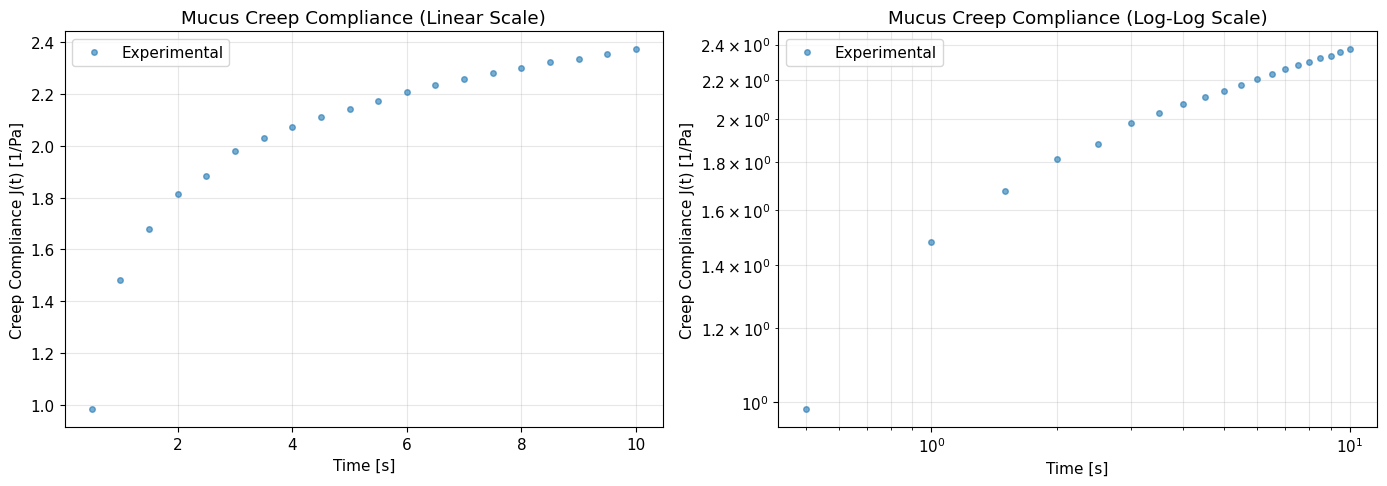


Assumed applied stress: σ₀ = 1.0 Pa
Strain range: 9.84e-01 - 2.37e+00


In [4]:
# Assume applied stress for conversion
sigma_0 = 1.0  # Pa (assumed - if σ₀=1, then γ=J)

# Convert compliance to strain
gamma_data = J_data * sigma_0

# Plot raw data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(time_data, J_data, 'o', markersize=4, alpha=0.6, label='Experimental')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Creep Compliance J(t) [1/Pa]')
axes[0].set_title('Mucus Creep Compliance (Linear Scale)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Log-log scale
axes[1].loglog(time_data, J_data, 'o', markersize=4, alpha=0.6, label='Experimental')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Creep Compliance J(t) [1/Pa]')
axes[1].set_title('Mucus Creep Compliance (Log-Log Scale)')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nAssumed applied stress: σ₀ = {sigma_0} Pa")
print(f"Strain range: {gamma_data[0]:.2e} - {gamma_data[-1]:.2e}")

## NLSQ Fitting: Fast Parameter Estimation

We use NLSQ optimization to fit the DMT creep model to data.

**Strategy**:
1. Create wrapper function that calls `model.simulate_creep()`
2. Interpolate simulation output to match data time points
3. Use NLSQ for fast fitting (5-270x faster than scipy)

In [5]:
# Initialize model with Maxwell elasticity
model = DMTLocal(closure="exponential", include_elasticity=True)

# Create ParameterSet for fitting using DMT model parameter names
from rheojax.core.parameters import ParameterSet

params = ParameterSet()
params.add('eta_inf', value=1e2, bounds=(1e0, 1e6))      # Low-structure viscosity [Pa·s]
params.add('eta_0', value=1e5, bounds=(1e2, 1e8))        # High-structure viscosity [Pa·s]
params.add('t_eq', value=10.0, bounds=(0.1, 1e3))        # Equilibration time [s]
params.add('a', value=1.0, bounds=(0.1, 10.0))           # Structure breakdown rate
params.add('c', value=1.0, bounds=(0.5, 2.0))            # Shear-rate exponent
params.add('G0', value=100.0, bounds=(1.0, 1e4))         # Elastic modulus [Pa]
params.add('m_G', value=1.0, bounds=(0.1, 3.0))          # Structure exponent for G

print("Initial parameters:")
for name in params.keys():
    p = params[name]
    print(f"  {name}: {p.value:.2e} (bounds: {p.bounds})")

Initial parameters:
  eta_inf: 1.00e+02 (bounds: (1.0, 1000000.0))
  eta_0: 1.00e+05 (bounds: (100.0, 100000000.0))
  t_eq: 1.00e+01 (bounds: (0.1, 1000.0))
  a: 1.00e+00 (bounds: (0.1, 10.0))
  c: 1.00e+00 (bounds: (0.5, 2.0))
  G0: 1.00e+02 (bounds: (1.0, 10000.0))
  m_G: 1.00e+00 (bounds: (0.1, 3.0))


In [6]:
# Create scipy-compatible wrapper function
def dmt_creep_fn(t_data, eta_inf, eta_0, t_eq, a, c, G0, m_G):
    """
    Wrapper for DMT creep simulation using scipy-compatible signature.
    
    Args:
        t_data: Time points for evaluation
        eta_inf, eta_0, t_eq, a, c, G0, m_G: Model parameters
    
    Returns:
        Predicted strain values at t_data points
    """
    # Set model parameters
    model.parameters.set_value("eta_inf", float(eta_inf))
    model.parameters.set_value("eta_0", float(eta_0))
    model.parameters.set_value("t_eq", float(t_eq))
    model.parameters.set_value("a", float(a))
    model.parameters.set_value("c", float(c))
    model.parameters.set_value("G0", float(G0))
    model.parameters.set_value("m_G", float(m_G))
    
    # Simulate creep (returns time, strain, strain_rate, lambda)
    t_end = float(np.max(t_data)) * 1.2  # Simulate slightly beyond last data point
    dt = t_end / 500  # Use 500 points
    t_sim, gamma_sim, gamma_dot_sim, lambda_sim = model.simulate_creep(
        sigma_0=sigma_0,
        t_end=t_end,
        dt=dt
    )
    
    # Interpolate to data time points
    gamma_pred = np.interp(t_data, np.array(t_sim), np.array(gamma_sim))
    
    return gamma_pred

print("Created scipy-compatible wrapper function for DMT creep simulation")

Created scipy-compatible wrapper function for DMT creep simulation


In [7]:
# Perform optimization using scipy.optimize.curve_fit
print("Starting optimization with scipy.optimize.curve_fit...")

# Helper function for computing fit quality
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Initial guesses - eta_inf must be < 100 (model constraint)
p0 = [10.0, 1e5, 10.0, 1.0, 1.0, 100.0, 1.0]

# Bounds (lower, upper) - must match DMT model constraints
# eta_inf: (0.001, 100.0), eta_0: (100.0, 1e8), t_eq: (0.1, 10000.0)
# a: (0.001, 100.0), c: (0.1, 2.0), G0: (1.0, 1e6), m_G: (0.5, 2.0)
bounds = (
    [0.001, 1e2, 0.1, 0.1, 0.5, 1.0, 0.5],    # lower
    [99.9, 1e8, 1e4, 10.0, 2.0, 1e4, 2.0]     # upper (eta_inf < 100 to avoid bound violation)
)

popt, pcov = curve_fit(
    dmt_creep_fn,
    time_data,
    gamma_data,
    p0=p0,
    bounds=bounds,
    maxfev=5000
)

# Parameter names
param_names = ['eta_inf', 'eta_0', 't_eq', 'a', 'c', 'G0', 'm_G']

# Compute predictions and metrics
gamma_pred = dmt_creep_fn(time_data, *popt)
metrics = compute_fit_quality(gamma_data, gamma_pred)

print(f"\nOptimization converged successfully")
print(f"R² score: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6e}")
print(f"\nFitted parameters:")

fitted_params = {}
for name, value in zip(param_names, popt):
    fitted_params[name] = float(value)
    print(f"  {name}: {value:.6e}")

# Update model with fitted parameters
for name, value in fitted_params.items():
    model.parameters.set_value(name, value)

Starting optimization with scipy.optimize.curve_fit...



Optimization converged successfully
R² score: -2.248304
RMSE: 6.097885e-01

Fitted parameters:
  eta_inf: 2.068871e-02
  eta_0: 2.545886e+04
  t_eq: 2.027957e-01
  a: 9.996468e+00
  c: 5.000007e-01
  G0: 1.000628e+00
  m_G: 1.999718e+00


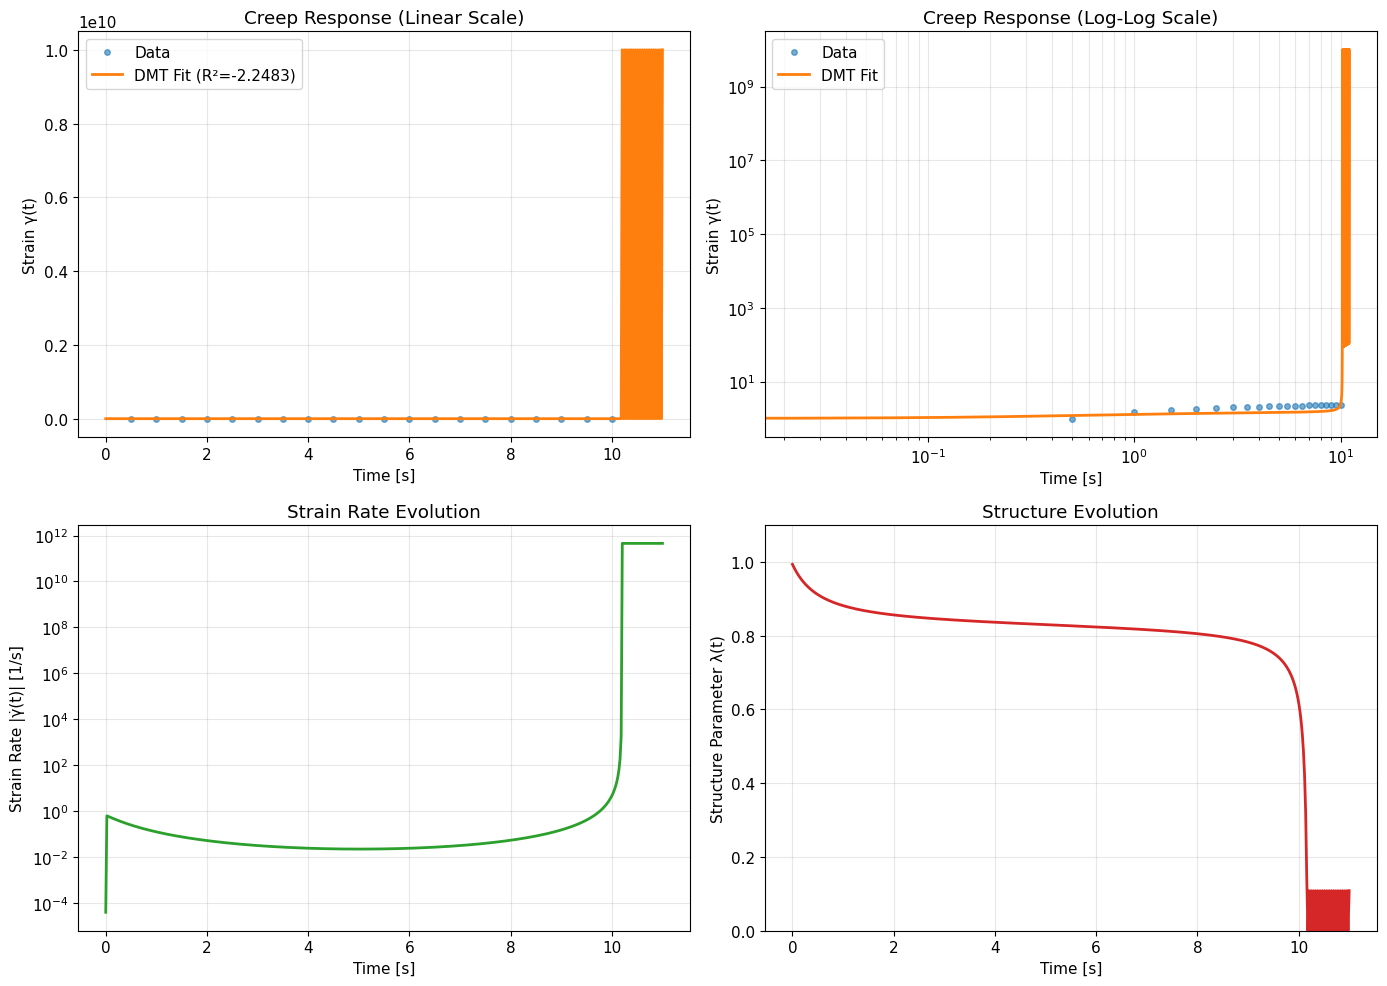

In [8]:
# Generate fitted curve
t_end_fit = time_data[-1] * 1.1
dt_fit = t_end_fit / 500
t_fit, gamma_fit, gamma_dot_fit, lambda_fit = model.simulate_creep(
    sigma_0=sigma_0,
    t_end=t_end_fit,
    dt=dt_fit
)

# Plot fit vs data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain - Linear scale
axes[0, 0].plot(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data')
axes[0, 0].plot(t_fit, gamma_fit, '-', linewidth=2, label=f'DMT Fit (R²={metrics["R2"]:.4f})')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Strain γ(t)')
axes[0, 0].set_title('Creep Response (Linear Scale)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Strain - Log-log scale
axes[0, 1].loglog(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data')
axes[0, 1].loglog(t_fit, gamma_fit, '-', linewidth=2, label='DMT Fit')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Strain γ(t)')
axes[0, 1].set_title('Creep Response (Log-Log Scale)')
axes[0, 1].grid(True, alpha=0.3, which='both')
axes[0, 1].legend()

# Strain rate evolution
axes[1, 0].semilogy(t_fit, jnp.abs(gamma_dot_fit), '-', linewidth=2, color='C2')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Strain Rate |γ̇(t)| [1/s]')
axes[1, 0].set_title('Strain Rate Evolution')
axes[1, 0].grid(True, alpha=0.3)

# Structure parameter evolution
axes[1, 1].plot(t_fit, lambda_fit, '-', linewidth=2, color='C3')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Structure Parameter λ(t)')
axes[1, 1].set_title('Structure Evolution')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.1])

plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian Inference: Uncertainty Quantification

Use NUTS sampling to:
1. Quantify parameter uncertainty
2. Check parameter correlations
3. Generate posterior predictive distributions

In [9]:
# Set model attributes for Bayesian inference
model._sigma_applied = sigma_0
model._creep_lam_init = 1.0  # Assume fully structured initial state

print("Starting Bayesian inference (NUTS)...")
print("This will take 2-5 minutes with 4 chains...")

# Bayesian inference with NLSQ warm-start
posterior_result = model.fit_bayesian(
    time_data,
    gamma_data,
    test_mode='creep',
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    seed=42
)

print("\nBayesian inference complete!")

Starting Bayesian inference (NUTS)...
This will take 2-5 minutes with 4 chains...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:02<1:57:23,  2.35s/it]

warmup:   0%|          | 2/3000 [00:04<2:01:04,  2.42s/it]

warmup:   1%|          | 25/3000 [00:04<06:07,  8.10it/s] 

warmup:   2%|▏         | 55/3000 [00:05<02:18, 21.34it/s]

warmup:   3%|▎         | 99/3000 [00:05<01:01, 46.87it/s]

warmup:   4%|▍         | 126/3000 [00:05<00:52, 54.75it/s]

warmup:   5%|▍         | 147/3000 [00:06<00:58, 48.86it/s]

warmup:   5%|▌         | 163/3000 [00:06<01:05, 43.54it/s]

warmup:   6%|▌         | 175/3000 [00:06<01:01, 46.17it/s]

warmup:   6%|▌         | 185/3000 [00:07<01:20, 35.13it/s]

warmup:   6%|▋         | 193/3000 [00:07<01:37, 28.77it/s]

warmup:   7%|▋         | 199/3000 [00:08<01:53, 24.71it/s]

warmup:   7%|▋         | 204/3000 [00:08<02:05, 22.25it/s]

warmup:   7%|▋         | 208/3000 [00:08<02:15, 20.58it/s]

warmup:   7%|▋         | 211/3000 [00:09<02:25, 19.21it/s]

warmup:   7%|▋         | 214/3000 [00:09<02:34, 18.07it/s]

warmup:   7%|▋         | 217/3000 [00:09<02:32, 18.23it/s]

warmup:   7%|▋         | 220/3000 [00:09<02:27, 18.90it/s]

warmup:   7%|▋         | 223/3000 [00:09<02:32, 18.20it/s]

warmup:   8%|▊         | 225/3000 [00:09<02:37, 17.59it/s]

warmup:   8%|▊         | 227/3000 [00:10<02:47, 16.52it/s]

warmup:   8%|▊         | 230/3000 [00:10<02:38, 17.51it/s]

warmup:   8%|▊         | 232/3000 [00:10<02:36, 17.68it/s]

warmup:   8%|▊         | 234/3000 [00:10<02:34, 17.90it/s]

warmup:   8%|▊         | 236/3000 [00:10<02:38, 17.49it/s]

warmup:   8%|▊         | 238/3000 [00:10<02:45, 16.72it/s]

warmup:   8%|▊         | 240/3000 [00:10<02:41, 17.09it/s]

warmup:   8%|▊         | 242/3000 [00:10<02:44, 16.75it/s]

warmup:   8%|▊         | 244/3000 [00:11<02:56, 15.59it/s]

warmup:   8%|▊         | 246/3000 [00:11<02:53, 15.90it/s]

warmup:   8%|▊         | 248/3000 [00:11<02:57, 15.50it/s]

warmup:   8%|▊         | 250/3000 [00:11<02:55, 15.69it/s]

warmup:   8%|▊         | 254/3000 [00:11<02:06, 21.70it/s]

warmup:   9%|▊         | 258/3000 [00:11<01:58, 23.12it/s]

warmup:   9%|▊         | 261/3000 [00:11<02:22, 19.24it/s]

warmup:   9%|▉         | 264/3000 [00:12<02:31, 18.04it/s]

warmup:   9%|▉         | 266/3000 [00:12<02:30, 18.15it/s]

warmup:   9%|▉         | 270/3000 [00:12<02:16, 20.05it/s]

warmup:   9%|▉         | 273/3000 [00:12<02:22, 19.08it/s]

warmup:   9%|▉         | 275/3000 [00:12<02:27, 18.44it/s]

warmup:   9%|▉         | 277/3000 [00:12<02:31, 17.94it/s]

warmup:   9%|▉         | 279/3000 [00:12<02:38, 17.21it/s]

warmup:   9%|▉         | 281/3000 [00:13<02:43, 16.68it/s]

warmup:   9%|▉         | 283/3000 [00:13<02:43, 16.63it/s]

warmup:  10%|▉         | 285/3000 [00:13<02:43, 16.65it/s]

warmup:  10%|▉         | 287/3000 [00:13<02:46, 16.30it/s]

warmup:  10%|▉         | 289/3000 [00:13<02:44, 16.46it/s]

warmup:  10%|▉         | 291/3000 [00:13<02:44, 16.45it/s]

warmup:  10%|▉         | 293/3000 [00:13<02:44, 16.47it/s]

warmup:  10%|▉         | 295/3000 [00:13<02:56, 15.30it/s]

warmup:  10%|▉         | 297/3000 [00:14<02:56, 15.36it/s]

warmup:  10%|▉         | 299/3000 [00:14<02:56, 15.27it/s]

warmup:  10%|█         | 301/3000 [00:14<03:03, 14.71it/s]

warmup:  10%|█         | 303/3000 [00:14<02:56, 15.31it/s]

warmup:  10%|█         | 305/3000 [00:14<02:54, 15.47it/s]

warmup:  10%|█         | 307/3000 [00:14<02:53, 15.50it/s]

warmup:  10%|█         | 309/3000 [00:14<02:45, 16.23it/s]

warmup:  10%|█         | 311/3000 [00:14<02:44, 16.36it/s]

warmup:  10%|█         | 313/3000 [00:15<02:45, 16.23it/s]

warmup:  10%|█         | 315/3000 [00:15<02:39, 16.84it/s]

warmup:  11%|█         | 317/3000 [00:15<02:38, 16.92it/s]

warmup:  11%|█         | 319/3000 [00:15<02:46, 16.13it/s]

warmup:  11%|█         | 321/3000 [00:15<02:42, 16.47it/s]

warmup:  11%|█         | 323/3000 [00:15<02:46, 16.05it/s]

warmup:  11%|█         | 325/3000 [00:15<02:51, 15.63it/s]

warmup:  11%|█         | 327/3000 [00:15<02:50, 15.71it/s]

warmup:  11%|█         | 329/3000 [00:16<02:44, 16.23it/s]

warmup:  11%|█         | 331/3000 [00:16<02:42, 16.45it/s]

warmup:  11%|█         | 334/3000 [00:16<02:32, 17.50it/s]

warmup:  11%|█         | 336/3000 [00:16<02:28, 17.92it/s]

warmup:  11%|█▏        | 338/3000 [00:16<02:28, 17.95it/s]

warmup:  11%|█▏        | 340/3000 [00:16<02:29, 17.76it/s]

warmup:  11%|█▏        | 342/3000 [00:16<02:32, 17.46it/s]

warmup:  11%|█▏        | 344/3000 [00:16<02:43, 16.25it/s]

warmup:  12%|█▏        | 346/3000 [00:17<02:45, 16.03it/s]

warmup:  12%|█▏        | 348/3000 [00:17<02:48, 15.78it/s]

warmup:  12%|█▏        | 350/3000 [00:17<02:58, 14.83it/s]

warmup:  12%|█▏        | 352/3000 [00:17<02:51, 15.42it/s]

warmup:  12%|█▏        | 354/3000 [00:17<02:51, 15.45it/s]

warmup:  12%|█▏        | 356/3000 [00:17<03:07, 14.08it/s]

warmup:  12%|█▏        | 358/3000 [00:17<03:29, 12.58it/s]

warmup:  12%|█▏        | 360/3000 [00:18<03:22, 13.02it/s]

warmup:  12%|█▏        | 362/3000 [00:18<04:03, 10.83it/s]

warmup:  12%|█▏        | 364/3000 [00:18<03:39, 11.99it/s]

warmup:  12%|█▏        | 366/3000 [00:18<03:25, 12.83it/s]

warmup:  12%|█▏        | 368/3000 [00:18<03:14, 13.56it/s]

warmup:  12%|█▏        | 370/3000 [00:18<03:05, 14.18it/s]

warmup:  12%|█▏        | 372/3000 [00:18<02:56, 14.88it/s]

warmup:  12%|█▏        | 374/3000 [00:19<02:57, 14.83it/s]

warmup:  13%|█▎        | 376/3000 [00:19<03:07, 13.97it/s]

warmup:  13%|█▎        | 378/3000 [00:19<02:52, 15.16it/s]

warmup:  13%|█▎        | 380/3000 [00:19<02:48, 15.51it/s]

warmup:  13%|█▎        | 382/3000 [00:19<02:42, 16.15it/s]

warmup:  13%|█▎        | 384/3000 [00:19<02:37, 16.65it/s]

warmup:  13%|█▎        | 386/3000 [00:19<02:40, 16.29it/s]

warmup:  13%|█▎        | 388/3000 [00:19<02:43, 15.98it/s]

warmup:  13%|█▎        | 390/3000 [00:20<02:46, 15.71it/s]

warmup:  13%|█▎        | 392/3000 [00:20<02:46, 15.62it/s]

warmup:  13%|█▎        | 394/3000 [00:20<02:55, 14.86it/s]

warmup:  13%|█▎        | 396/3000 [00:20<03:04, 14.10it/s]

warmup:  13%|█▎        | 398/3000 [00:20<02:59, 14.48it/s]

warmup:  13%|█▎        | 400/3000 [00:20<03:04, 14.07it/s]

warmup:  13%|█▎        | 402/3000 [00:20<03:03, 14.14it/s]

warmup:  13%|█▎        | 404/3000 [00:21<03:10, 13.63it/s]

warmup:  14%|█▎        | 406/3000 [00:21<02:55, 14.81it/s]

warmup:  14%|█▎        | 408/3000 [00:21<02:52, 15.05it/s]

warmup:  14%|█▎        | 410/3000 [00:21<02:44, 15.79it/s]

warmup:  14%|█▎        | 412/3000 [00:21<02:40, 16.10it/s]

warmup:  14%|█▍        | 414/3000 [00:21<02:43, 15.84it/s]

warmup:  14%|█▍        | 416/3000 [00:21<02:41, 16.02it/s]

warmup:  14%|█▍        | 418/3000 [00:22<02:59, 14.40it/s]

warmup:  14%|█▍        | 420/3000 [00:22<03:23, 12.66it/s]

warmup:  14%|█▍        | 422/3000 [00:22<03:28, 12.34it/s]

warmup:  14%|█▍        | 424/3000 [00:22<03:17, 13.02it/s]

warmup:  14%|█▍        | 426/3000 [00:22<03:03, 14.06it/s]

warmup:  14%|█▍        | 428/3000 [00:22<02:53, 14.78it/s]

warmup:  14%|█▍        | 430/3000 [00:22<02:47, 15.30it/s]

warmup:  14%|█▍        | 432/3000 [00:22<02:38, 16.18it/s]

warmup:  14%|█▍        | 434/3000 [00:23<02:40, 15.97it/s]

warmup:  15%|█▍        | 436/3000 [00:23<02:41, 15.90it/s]

warmup:  15%|█▍        | 438/3000 [00:23<02:42, 15.77it/s]

warmup:  15%|█▍        | 440/3000 [00:23<02:43, 15.66it/s]

warmup:  15%|█▍        | 442/3000 [00:23<02:39, 16.06it/s]

warmup:  15%|█▍        | 444/3000 [00:23<02:40, 15.94it/s]

warmup:  15%|█▍        | 446/3000 [00:23<02:39, 16.04it/s]

warmup:  15%|█▍        | 448/3000 [00:24<03:20, 12.76it/s]

warmup:  15%|█▌        | 450/3000 [00:24<04:46,  8.92it/s]

warmup:  15%|█▌        | 452/3000 [00:24<04:57,  8.56it/s]

warmup:  15%|█▌        | 454/3000 [00:24<04:48,  8.82it/s]

warmup:  15%|█▌        | 456/3000 [00:25<04:11, 10.13it/s]

warmup:  15%|█▌        | 458/3000 [00:25<04:03, 10.45it/s]

warmup:  15%|█▌        | 460/3000 [00:25<04:21,  9.73it/s]

warmup:  15%|█▌        | 462/3000 [00:25<04:02, 10.49it/s]

warmup:  15%|█▌        | 464/3000 [00:25<04:16,  9.90it/s]

warmup:  16%|█▌        | 466/3000 [00:26<04:01, 10.48it/s]

warmup:  16%|█▌        | 468/3000 [00:26<03:57, 10.64it/s]

warmup:  16%|█▌        | 470/3000 [00:26<03:57, 10.66it/s]

warmup:  16%|█▌        | 472/3000 [00:26<03:50, 10.97it/s]

warmup:  16%|█▌        | 474/3000 [00:26<04:33,  9.22it/s]

warmup:  16%|█▌        | 476/3000 [00:27<04:32,  9.27it/s]

warmup:  16%|█▌        | 478/3000 [00:27<03:57, 10.64it/s]

warmup:  16%|█▌        | 480/3000 [00:27<03:29, 12.01it/s]

warmup:  16%|█▌        | 482/3000 [00:27<03:06, 13.47it/s]

warmup:  16%|█▌        | 484/3000 [00:27<02:52, 14.61it/s]

warmup:  16%|█▌        | 486/3000 [00:27<02:46, 15.13it/s]

warmup:  16%|█▋        | 488/3000 [00:27<03:19, 12.58it/s]

warmup:  16%|█▋        | 490/3000 [00:28<04:23,  9.53it/s]

warmup:  16%|█▋        | 492/3000 [00:28<04:46,  8.77it/s]

warmup:  16%|█▋        | 494/3000 [00:28<04:18,  9.69it/s]

warmup:  17%|█▋        | 496/3000 [00:28<04:19,  9.67it/s]

warmup:  17%|█▋        | 498/3000 [00:29<03:56, 10.57it/s]

warmup:  17%|█▋        | 500/3000 [00:29<03:36, 11.56it/s]

warmup:  17%|█▋        | 502/3000 [00:29<03:18, 12.58it/s]

warmup:  17%|█▋        | 504/3000 [00:29<03:22, 12.30it/s]

warmup:  17%|█▋        | 506/3000 [00:29<03:14, 12.80it/s]

warmup:  17%|█▋        | 508/3000 [00:29<03:03, 13.62it/s]

warmup:  17%|█▋        | 510/3000 [00:29<02:54, 14.29it/s]

warmup:  17%|█▋        | 512/3000 [00:30<03:08, 13.22it/s]

warmup:  17%|█▋        | 514/3000 [00:30<03:27, 12.00it/s]

warmup:  17%|█▋        | 516/3000 [00:30<03:23, 12.20it/s]

warmup:  17%|█▋        | 518/3000 [00:30<03:15, 12.72it/s]

warmup:  17%|█▋        | 520/3000 [00:30<03:15, 12.66it/s]

warmup:  17%|█▋        | 522/3000 [00:30<03:09, 13.06it/s]

warmup:  17%|█▋        | 524/3000 [00:30<03:10, 13.03it/s]

warmup:  18%|█▊        | 526/3000 [00:31<03:18, 12.43it/s]

warmup:  18%|█▊        | 528/3000 [00:31<03:09, 13.06it/s]

warmup:  18%|█▊        | 530/3000 [00:31<02:58, 13.86it/s]

warmup:  18%|█▊        | 532/3000 [00:31<02:44, 14.97it/s]

warmup:  18%|█▊        | 534/3000 [00:31<02:34, 15.99it/s]

warmup:  18%|█▊        | 536/3000 [00:31<02:28, 16.56it/s]

warmup:  18%|█▊        | 538/3000 [00:31<02:26, 16.76it/s]

warmup:  18%|█▊        | 540/3000 [00:32<03:52, 10.59it/s]

warmup:  18%|█▊        | 542/3000 [00:32<03:56, 10.38it/s]

warmup:  18%|█▊        | 544/3000 [00:32<03:35, 11.39it/s]

warmup:  18%|█▊        | 546/3000 [00:32<03:48, 10.74it/s]

warmup:  18%|█▊        | 548/3000 [00:32<04:04, 10.04it/s]

warmup:  18%|█▊        | 550/3000 [00:33<03:33, 11.47it/s]

warmup:  18%|█▊        | 552/3000 [00:33<03:13, 12.63it/s]

warmup:  18%|█▊        | 554/3000 [00:33<03:22, 12.06it/s]

warmup:  19%|█▊        | 556/3000 [00:33<03:38, 11.21it/s]

warmup:  19%|█▊        | 558/3000 [00:33<03:50, 10.58it/s]

warmup:  19%|█▊        | 560/3000 [00:34<03:55, 10.37it/s]

warmup:  19%|█▊        | 562/3000 [00:34<04:02, 10.05it/s]

warmup:  19%|█▉        | 564/3000 [00:34<03:50, 10.56it/s]

warmup:  19%|█▉        | 566/3000 [00:34<03:53, 10.42it/s]

warmup:  19%|█▉        | 568/3000 [00:34<03:57, 10.24it/s]

warmup:  19%|█▉        | 570/3000 [00:34<03:32, 11.45it/s]

warmup:  19%|█▉        | 572/3000 [00:35<03:19, 12.17it/s]

warmup:  19%|█▉        | 574/3000 [00:35<03:04, 13.16it/s]

warmup:  19%|█▉        | 576/3000 [00:35<02:53, 13.94it/s]

warmup:  19%|█▉        | 578/3000 [00:35<03:28, 11.62it/s]

warmup:  19%|█▉        | 580/3000 [00:35<03:18, 12.20it/s]

warmup:  19%|█▉        | 582/3000 [00:35<03:00, 13.43it/s]

warmup:  19%|█▉        | 584/3000 [00:35<02:56, 13.69it/s]

warmup:  20%|█▉        | 586/3000 [00:36<02:59, 13.47it/s]

warmup:  20%|█▉        | 588/3000 [00:36<03:21, 11.99it/s]

warmup:  20%|█▉        | 590/3000 [00:36<03:12, 12.53it/s]

warmup:  20%|█▉        | 592/3000 [00:36<03:01, 13.24it/s]

warmup:  20%|█▉        | 594/3000 [00:36<03:02, 13.18it/s]

warmup:  20%|█▉        | 596/3000 [00:36<03:09, 12.68it/s]

warmup:  20%|█▉        | 598/3000 [00:37<03:01, 13.25it/s]

warmup:  20%|██        | 600/3000 [00:37<02:52, 13.90it/s]

warmup:  20%|██        | 602/3000 [00:37<02:54, 13.77it/s]

warmup:  20%|██        | 604/3000 [00:37<02:48, 14.21it/s]

warmup:  20%|██        | 606/3000 [00:37<02:42, 14.74it/s]

warmup:  20%|██        | 608/3000 [00:37<02:40, 14.91it/s]

warmup:  20%|██        | 610/3000 [00:37<02:38, 15.12it/s]

warmup:  20%|██        | 612/3000 [00:37<02:35, 15.34it/s]

warmup:  20%|██        | 614/3000 [00:38<03:17, 12.05it/s]

warmup:  21%|██        | 616/3000 [00:38<03:20, 11.86it/s]

warmup:  21%|██        | 618/3000 [00:38<03:11, 12.45it/s]

warmup:  21%|██        | 620/3000 [00:38<03:07, 12.71it/s]

warmup:  21%|██        | 622/3000 [00:38<03:05, 12.85it/s]

warmup:  21%|██        | 624/3000 [00:38<03:07, 12.67it/s]

warmup:  21%|██        | 626/3000 [00:39<03:04, 12.84it/s]

warmup:  21%|██        | 628/3000 [00:39<03:05, 12.80it/s]

warmup:  21%|██        | 630/3000 [00:39<03:00, 13.12it/s]

warmup:  21%|██        | 632/3000 [00:39<03:01, 13.02it/s]

warmup:  21%|██        | 634/3000 [00:39<02:47, 14.09it/s]

warmup:  21%|██        | 636/3000 [00:39<02:58, 13.21it/s]

warmup:  21%|██▏       | 638/3000 [00:40<02:50, 13.89it/s]

warmup:  21%|██▏       | 640/3000 [00:40<02:49, 13.94it/s]

warmup:  21%|██▏       | 642/3000 [00:40<02:41, 14.60it/s]

warmup:  21%|██▏       | 644/3000 [00:40<02:39, 14.81it/s]

warmup:  22%|██▏       | 646/3000 [00:40<02:33, 15.30it/s]

warmup:  22%|██▏       | 648/3000 [00:40<02:33, 15.28it/s]

warmup:  22%|██▏       | 650/3000 [00:40<02:27, 15.91it/s]

warmup:  22%|██▏       | 652/3000 [00:40<02:23, 16.31it/s]

warmup:  22%|██▏       | 654/3000 [00:41<02:30, 15.58it/s]

warmup:  22%|██▏       | 656/3000 [00:41<02:31, 15.48it/s]

warmup:  22%|██▏       | 658/3000 [00:41<02:32, 15.40it/s]

warmup:  22%|██▏       | 660/3000 [00:41<02:29, 15.65it/s]

warmup:  22%|██▏       | 662/3000 [00:41<02:35, 15.00it/s]

warmup:  22%|██▏       | 664/3000 [00:41<02:34, 15.09it/s]

warmup:  22%|██▏       | 666/3000 [00:41<02:30, 15.51it/s]

warmup:  22%|██▏       | 668/3000 [00:41<02:26, 15.97it/s]

warmup:  22%|██▏       | 670/3000 [00:42<02:24, 16.17it/s]

warmup:  22%|██▏       | 672/3000 [00:42<02:22, 16.35it/s]

warmup:  22%|██▏       | 674/3000 [00:42<02:22, 16.38it/s]

warmup:  23%|██▎       | 676/3000 [00:42<02:17, 16.86it/s]

warmup:  23%|██▎       | 678/3000 [00:42<02:16, 16.97it/s]

warmup:  23%|██▎       | 680/3000 [00:42<02:14, 17.20it/s]

warmup:  23%|██▎       | 682/3000 [00:42<02:12, 17.43it/s]

warmup:  23%|██▎       | 684/3000 [00:42<02:15, 17.11it/s]

warmup:  23%|██▎       | 686/3000 [00:42<02:19, 16.59it/s]

warmup:  23%|██▎       | 688/3000 [00:43<02:19, 16.53it/s]

warmup:  23%|██▎       | 690/3000 [00:43<02:25, 15.86it/s]

warmup:  23%|██▎       | 692/3000 [00:43<02:31, 15.27it/s]

warmup:  23%|██▎       | 694/3000 [00:43<02:34, 14.91it/s]

warmup:  23%|██▎       | 696/3000 [00:43<02:36, 14.73it/s]

warmup:  23%|██▎       | 698/3000 [00:43<02:30, 15.34it/s]

warmup:  23%|██▎       | 700/3000 [00:43<02:26, 15.72it/s]

warmup:  23%|██▎       | 702/3000 [00:44<02:24, 15.95it/s]

warmup:  23%|██▎       | 704/3000 [00:44<02:20, 16.35it/s]

warmup:  24%|██▎       | 706/3000 [00:44<02:23, 16.00it/s]

warmup:  24%|██▎       | 708/3000 [00:44<02:25, 15.74it/s]

warmup:  24%|██▎       | 710/3000 [00:44<02:29, 15.35it/s]

warmup:  24%|██▎       | 712/3000 [00:44<02:23, 15.96it/s]

warmup:  24%|██▍       | 714/3000 [00:44<02:30, 15.14it/s]

warmup:  24%|██▍       | 716/3000 [00:44<02:36, 14.62it/s]

warmup:  24%|██▍       | 718/3000 [00:45<02:28, 15.33it/s]

warmup:  24%|██▍       | 720/3000 [00:45<02:22, 15.96it/s]

warmup:  24%|██▍       | 722/3000 [00:45<02:23, 15.93it/s]

warmup:  24%|██▍       | 724/3000 [00:45<02:20, 16.22it/s]

warmup:  24%|██▍       | 726/3000 [00:45<02:16, 16.66it/s]

warmup:  24%|██▍       | 728/3000 [00:45<02:12, 17.16it/s]

warmup:  24%|██▍       | 730/3000 [00:45<02:14, 16.86it/s]

warmup:  24%|██▍       | 732/3000 [00:45<02:13, 16.97it/s]

warmup:  24%|██▍       | 734/3000 [00:46<02:20, 16.18it/s]

warmup:  25%|██▍       | 736/3000 [00:46<02:26, 15.48it/s]

warmup:  25%|██▍       | 738/3000 [00:46<02:30, 15.04it/s]

warmup:  25%|██▍       | 740/3000 [00:46<02:33, 14.71it/s]

warmup:  25%|██▍       | 742/3000 [00:46<02:34, 14.61it/s]

warmup:  25%|██▍       | 744/3000 [00:46<02:31, 14.93it/s]

warmup:  25%|██▍       | 746/3000 [00:46<02:23, 15.66it/s]

warmup:  25%|██▍       | 748/3000 [00:46<02:25, 15.49it/s]

warmup:  25%|██▌       | 750/3000 [00:47<02:26, 15.36it/s]

warmup:  25%|██▌       | 752/3000 [00:47<02:22, 15.77it/s]

warmup:  25%|██▌       | 754/3000 [00:47<02:28, 15.11it/s]

warmup:  25%|██▌       | 756/3000 [00:47<02:31, 14.80it/s]

warmup:  25%|██▌       | 758/3000 [00:47<02:24, 15.52it/s]

warmup:  25%|██▌       | 760/3000 [00:47<02:30, 14.88it/s]

warmup:  25%|██▌       | 762/3000 [00:47<02:32, 14.65it/s]

warmup:  25%|██▌       | 764/3000 [00:48<02:50, 13.10it/s]

warmup:  26%|██▌       | 766/3000 [00:48<02:47, 13.30it/s]

warmup:  26%|██▌       | 768/3000 [00:48<02:31, 14.71it/s]

warmup:  26%|██▌       | 770/3000 [00:48<02:25, 15.32it/s]

warmup:  26%|██▌       | 772/3000 [00:48<02:24, 15.46it/s]

warmup:  26%|██▌       | 774/3000 [00:48<02:16, 16.26it/s]

warmup:  26%|██▌       | 776/3000 [00:48<02:12, 16.85it/s]

warmup:  26%|██▌       | 778/3000 [00:48<02:08, 17.31it/s]

warmup:  26%|██▌       | 780/3000 [00:49<02:10, 16.99it/s]

warmup:  26%|██▌       | 782/3000 [00:49<02:22, 15.58it/s]

warmup:  26%|██▌       | 784/3000 [00:49<02:21, 15.61it/s]

warmup:  26%|██▌       | 786/3000 [00:49<02:27, 14.99it/s]

warmup:  26%|██▋       | 788/3000 [00:49<02:45, 13.34it/s]

warmup:  26%|██▋       | 790/3000 [00:49<02:36, 14.08it/s]

warmup:  26%|██▋       | 792/3000 [00:49<02:24, 15.33it/s]

warmup:  26%|██▋       | 794/3000 [00:49<02:16, 16.20it/s]

warmup:  27%|██▋       | 796/3000 [00:50<02:10, 16.92it/s]

warmup:  27%|██▋       | 798/3000 [00:50<02:15, 16.27it/s]

warmup:  27%|██▋       | 800/3000 [00:50<02:11, 16.73it/s]

warmup:  27%|██▋       | 802/3000 [00:50<02:11, 16.77it/s]

warmup:  27%|██▋       | 804/3000 [00:50<02:12, 16.56it/s]

warmup:  27%|██▋       | 806/3000 [00:50<02:15, 16.23it/s]

warmup:  27%|██▋       | 808/3000 [00:50<02:28, 14.74it/s]

warmup:  27%|██▋       | 810/3000 [00:51<02:27, 14.86it/s]

warmup:  27%|██▋       | 812/3000 [00:51<02:37, 13.89it/s]

warmup:  27%|██▋       | 814/3000 [00:51<03:15, 11.18it/s]

warmup:  27%|██▋       | 816/3000 [00:51<03:01, 12.04it/s]

warmup:  27%|██▋       | 818/3000 [00:51<02:48, 12.97it/s]

warmup:  27%|██▋       | 820/3000 [00:51<02:32, 14.33it/s]

warmup:  27%|██▋       | 822/3000 [00:51<02:29, 14.56it/s]

warmup:  27%|██▋       | 824/3000 [00:52<02:22, 15.29it/s]

warmup:  28%|██▊       | 826/3000 [00:52<02:18, 15.67it/s]

warmup:  28%|██▊       | 828/3000 [00:52<02:22, 15.19it/s]

warmup:  28%|██▊       | 830/3000 [00:52<02:14, 16.09it/s]

warmup:  28%|██▊       | 832/3000 [00:52<02:14, 16.15it/s]

warmup:  28%|██▊       | 834/3000 [00:52<02:14, 16.07it/s]

warmup:  28%|██▊       | 836/3000 [00:52<02:18, 15.61it/s]

warmup:  28%|██▊       | 838/3000 [00:52<02:13, 16.25it/s]

warmup:  28%|██▊       | 840/3000 [00:53<02:16, 15.80it/s]

warmup:  28%|██▊       | 842/3000 [00:53<02:22, 15.16it/s]

warmup:  28%|██▊       | 844/3000 [00:53<02:24, 14.97it/s]

warmup:  28%|██▊       | 846/3000 [00:53<02:22, 15.07it/s]

warmup:  28%|██▊       | 848/3000 [00:53<02:20, 15.35it/s]

warmup:  28%|██▊       | 850/3000 [00:53<02:22, 15.14it/s]

warmup:  28%|██▊       | 852/3000 [00:53<02:21, 15.20it/s]

warmup:  28%|██▊       | 854/3000 [00:53<02:17, 15.60it/s]

warmup:  29%|██▊       | 856/3000 [00:54<02:17, 15.62it/s]

warmup:  29%|██▊       | 858/3000 [00:54<02:25, 14.77it/s]

warmup:  29%|██▊       | 860/3000 [00:54<02:23, 14.89it/s]

warmup:  29%|██▊       | 862/3000 [00:54<02:22, 14.98it/s]

warmup:  29%|██▉       | 864/3000 [00:54<02:19, 15.34it/s]

warmup:  29%|██▉       | 866/3000 [00:54<02:20, 15.22it/s]

warmup:  29%|██▉       | 868/3000 [00:54<02:18, 15.37it/s]

warmup:  29%|██▉       | 870/3000 [00:55<02:19, 15.22it/s]

warmup:  29%|██▉       | 872/3000 [00:55<02:18, 15.34it/s]

warmup:  29%|██▉       | 874/3000 [00:55<02:16, 15.56it/s]

warmup:  29%|██▉       | 876/3000 [00:55<02:20, 15.15it/s]

warmup:  29%|██▉       | 878/3000 [00:55<02:57, 11.94it/s]

warmup:  29%|██▉       | 880/3000 [00:55<02:45, 12.80it/s]

warmup:  29%|██▉       | 882/3000 [00:55<02:40, 13.21it/s]

warmup:  29%|██▉       | 884/3000 [00:56<02:31, 13.93it/s]

warmup:  30%|██▉       | 886/3000 [00:56<02:22, 14.80it/s]

warmup:  30%|██▉       | 888/3000 [00:56<02:16, 15.52it/s]

warmup:  30%|██▉       | 890/3000 [00:56<02:18, 15.21it/s]

warmup:  30%|██▉       | 892/3000 [00:56<02:15, 15.57it/s]

warmup:  30%|██▉       | 894/3000 [00:56<02:16, 15.42it/s]

warmup:  30%|██▉       | 896/3000 [00:56<02:13, 15.76it/s]

warmup:  30%|██▉       | 898/3000 [00:56<02:13, 15.77it/s]

warmup:  30%|███       | 900/3000 [00:57<02:30, 13.91it/s]

warmup:  30%|███       | 902/3000 [00:57<02:37, 13.31it/s]

warmup:  30%|███       | 904/3000 [00:57<02:38, 13.25it/s]

warmup:  30%|███       | 906/3000 [00:57<02:30, 13.94it/s]

warmup:  30%|███       | 908/3000 [00:57<02:22, 14.63it/s]

warmup:  30%|███       | 910/3000 [00:57<02:21, 14.76it/s]

warmup:  30%|███       | 912/3000 [00:57<02:19, 14.99it/s]

warmup:  30%|███       | 914/3000 [00:58<02:18, 15.11it/s]

warmup:  31%|███       | 916/3000 [00:58<02:14, 15.51it/s]

warmup:  31%|███       | 918/3000 [00:58<02:12, 15.73it/s]

warmup:  31%|███       | 920/3000 [00:58<02:11, 15.82it/s]

warmup:  31%|███       | 922/3000 [00:58<02:10, 15.95it/s]

warmup:  31%|███       | 924/3000 [00:58<02:14, 15.47it/s]

warmup:  31%|███       | 926/3000 [00:58<02:18, 14.98it/s]

warmup:  31%|███       | 928/3000 [00:58<02:12, 15.68it/s]

warmup:  31%|███       | 930/3000 [00:59<02:04, 16.63it/s]

warmup:  31%|███       | 932/3000 [00:59<02:14, 15.32it/s]

warmup:  31%|███       | 934/3000 [00:59<02:39, 12.96it/s]

warmup:  31%|███       | 936/3000 [00:59<02:31, 13.64it/s]

warmup:  31%|███▏      | 938/3000 [00:59<02:24, 14.22it/s]

warmup:  31%|███▏      | 940/3000 [00:59<02:27, 14.00it/s]

warmup:  31%|███▏      | 942/3000 [01:00<02:56, 11.63it/s]

warmup:  31%|███▏      | 944/3000 [01:00<03:00, 11.40it/s]

warmup:  32%|███▏      | 946/3000 [01:00<02:43, 12.55it/s]

warmup:  32%|███▏      | 948/3000 [01:00<03:17, 10.40it/s]

warmup:  32%|███▏      | 950/3000 [01:00<03:02, 11.22it/s]

warmup:  32%|███▏      | 952/3000 [01:00<02:50, 11.98it/s]

warmup:  32%|███▏      | 954/3000 [01:01<02:45, 12.36it/s]

warmup:  32%|███▏      | 956/3000 [01:01<02:42, 12.61it/s]

warmup:  32%|███▏      | 958/3000 [01:01<02:57, 11.51it/s]

warmup:  32%|███▏      | 960/3000 [01:01<03:02, 11.15it/s]

warmup:  32%|███▏      | 962/3000 [01:01<03:05, 10.98it/s]

warmup:  32%|███▏      | 964/3000 [01:02<03:13, 10.54it/s]

warmup:  32%|███▏      | 966/3000 [01:02<03:02, 11.12it/s]

warmup:  32%|███▏      | 968/3000 [01:02<03:18, 10.26it/s]

warmup:  32%|███▏      | 970/3000 [01:02<03:05, 10.95it/s]

warmup:  32%|███▏      | 972/3000 [01:02<02:51, 11.82it/s]

warmup:  32%|███▏      | 974/3000 [01:03<03:30,  9.62it/s]

warmup:  33%|███▎      | 976/3000 [01:03<03:09, 10.67it/s]

warmup:  33%|███▎      | 978/3000 [01:03<02:55, 11.52it/s]

warmup:  33%|███▎      | 980/3000 [01:03<02:42, 12.45it/s]

warmup:  33%|███▎      | 982/3000 [01:03<02:30, 13.43it/s]

warmup:  33%|███▎      | 984/3000 [01:03<02:19, 14.50it/s]

warmup:  33%|███▎      | 986/3000 [01:03<02:14, 14.95it/s]

warmup:  33%|███▎      | 988/3000 [01:03<02:16, 14.75it/s]

warmup:  33%|███▎      | 990/3000 [01:04<02:13, 15.11it/s]

warmup:  33%|███▎      | 992/3000 [01:04<02:11, 15.30it/s]

warmup:  33%|███▎      | 994/3000 [01:04<02:16, 14.68it/s]

warmup:  33%|███▎      | 996/3000 [01:04<02:15, 14.75it/s]

warmup:  33%|███▎      | 998/3000 [01:04<02:19, 14.38it/s]

warmup:  33%|███▎      | 1000/3000 [01:04<02:15, 14.74it/s]

sample:  33%|███▎      | 1002/3000 [01:04<02:10, 15.25it/s]

sample:  33%|███▎      | 1004/3000 [01:04<02:08, 15.51it/s]

sample:  34%|███▎      | 1006/3000 [01:05<02:12, 15.08it/s]

sample:  34%|███▎      | 1008/3000 [01:05<02:11, 15.20it/s]

sample:  34%|███▎      | 1010/3000 [01:05<02:12, 15.02it/s]

sample:  34%|███▎      | 1012/3000 [01:05<02:11, 15.16it/s]

sample:  34%|███▍      | 1014/3000 [01:05<02:09, 15.32it/s]

sample:  34%|███▍      | 1016/3000 [01:05<02:08, 15.42it/s]

sample:  34%|███▍      | 1018/3000 [01:05<02:07, 15.58it/s]

sample:  34%|███▍      | 1020/3000 [01:06<02:08, 15.44it/s]

sample:  34%|███▍      | 1022/3000 [01:06<02:08, 15.42it/s]

sample:  34%|███▍      | 1024/3000 [01:06<02:07, 15.47it/s]

sample:  34%|███▍      | 1026/3000 [01:06<02:07, 15.51it/s]

sample:  34%|███▍      | 1028/3000 [01:06<02:14, 14.63it/s]

sample:  34%|███▍      | 1030/3000 [01:06<02:25, 13.51it/s]

sample:  34%|███▍      | 1032/3000 [01:06<02:42, 12.14it/s]

sample:  34%|███▍      | 1034/3000 [01:07<02:32, 12.89it/s]

sample:  35%|███▍      | 1036/3000 [01:07<02:43, 12.04it/s]

sample:  35%|███▍      | 1038/3000 [01:07<02:53, 11.31it/s]

sample:  35%|███▍      | 1040/3000 [01:07<02:35, 12.58it/s]

sample:  35%|███▍      | 1042/3000 [01:07<02:30, 13.00it/s]

sample:  35%|███▍      | 1044/3000 [01:07<02:26, 13.35it/s]

sample:  35%|███▍      | 1046/3000 [01:07<02:17, 14.16it/s]

sample:  35%|███▍      | 1048/3000 [01:08<02:11, 14.79it/s]

sample:  35%|███▌      | 1050/3000 [01:08<02:09, 15.12it/s]

sample:  35%|███▌      | 1052/3000 [01:08<02:02, 15.86it/s]

sample:  35%|███▌      | 1054/3000 [01:08<01:59, 16.25it/s]

sample:  35%|███▌      | 1056/3000 [01:08<02:04, 15.56it/s]

sample:  35%|███▌      | 1058/3000 [01:08<01:59, 16.19it/s]

sample:  35%|███▌      | 1060/3000 [01:08<02:02, 15.86it/s]

sample:  35%|███▌      | 1062/3000 [01:08<02:02, 15.81it/s]

sample:  35%|███▌      | 1064/3000 [01:09<02:00, 16.06it/s]

sample:  36%|███▌      | 1066/3000 [01:09<01:59, 16.18it/s]

sample:  36%|███▌      | 1068/3000 [01:09<01:56, 16.65it/s]

sample:  36%|███▌      | 1070/3000 [01:09<01:56, 16.57it/s]

sample:  36%|███▌      | 1072/3000 [01:09<02:03, 15.65it/s]

sample:  36%|███▌      | 1074/3000 [01:09<02:17, 14.03it/s]

sample:  36%|███▌      | 1076/3000 [01:09<02:09, 14.87it/s]

sample:  36%|███▌      | 1078/3000 [01:10<02:03, 15.56it/s]

sample:  36%|███▌      | 1080/3000 [01:10<02:03, 15.59it/s]

sample:  36%|███▌      | 1082/3000 [01:10<02:05, 15.27it/s]

sample:  36%|███▌      | 1084/3000 [01:10<02:07, 15.02it/s]

sample:  36%|███▌      | 1086/3000 [01:10<02:10, 14.66it/s]

sample:  36%|███▋      | 1088/3000 [01:10<02:08, 14.86it/s]

sample:  36%|███▋      | 1090/3000 [01:10<02:06, 15.05it/s]

sample:  36%|███▋      | 1092/3000 [01:10<02:01, 15.66it/s]

sample:  36%|███▋      | 1094/3000 [01:11<01:58, 16.05it/s]

sample:  37%|███▋      | 1096/3000 [01:11<02:00, 15.80it/s]

sample:  37%|███▋      | 1098/3000 [01:11<02:00, 15.81it/s]

sample:  37%|███▋      | 1100/3000 [01:11<01:55, 16.44it/s]

sample:  37%|███▋      | 1102/3000 [01:11<01:53, 16.72it/s]

sample:  37%|███▋      | 1104/3000 [01:11<01:52, 16.84it/s]

sample:  37%|███▋      | 1106/3000 [01:11<01:54, 16.56it/s]

sample:  37%|███▋      | 1108/3000 [01:11<01:55, 16.34it/s]

sample:  37%|███▋      | 1110/3000 [01:12<01:56, 16.27it/s]

sample:  37%|███▋      | 1112/3000 [01:12<01:50, 17.04it/s]

sample:  37%|███▋      | 1114/3000 [01:12<01:48, 17.38it/s]

sample:  37%|███▋      | 1116/3000 [01:12<01:50, 17.01it/s]

sample:  37%|███▋      | 1118/3000 [01:12<01:50, 17.09it/s]

sample:  37%|███▋      | 1120/3000 [01:12<01:49, 17.23it/s]

sample:  37%|███▋      | 1122/3000 [01:12<01:48, 17.26it/s]

sample:  37%|███▋      | 1124/3000 [01:12<01:49, 17.15it/s]

sample:  38%|███▊      | 1126/3000 [01:12<01:58, 15.82it/s]

sample:  38%|███▊      | 1128/3000 [01:13<02:00, 15.48it/s]

sample:  38%|███▊      | 1130/3000 [01:13<02:02, 15.32it/s]

sample:  38%|███▊      | 1132/3000 [01:13<02:08, 14.50it/s]

sample:  38%|███▊      | 1134/3000 [01:13<02:05, 14.92it/s]

sample:  38%|███▊      | 1136/3000 [01:13<02:09, 14.36it/s]

sample:  38%|███▊      | 1138/3000 [01:13<02:07, 14.58it/s]

sample:  38%|███▊      | 1140/3000 [01:13<02:10, 14.29it/s]

sample:  38%|███▊      | 1142/3000 [01:14<02:03, 15.05it/s]

sample:  38%|███▊      | 1144/3000 [01:14<01:59, 15.57it/s]

sample:  38%|███▊      | 1146/3000 [01:14<01:58, 15.66it/s]

sample:  38%|███▊      | 1148/3000 [01:14<01:55, 16.03it/s]

sample:  38%|███▊      | 1150/3000 [01:14<01:53, 16.28it/s]

sample:  38%|███▊      | 1152/3000 [01:14<01:52, 16.36it/s]

sample:  38%|███▊      | 1154/3000 [01:14<01:55, 15.96it/s]

sample:  39%|███▊      | 1156/3000 [01:14<01:58, 15.53it/s]

sample:  39%|███▊      | 1158/3000 [01:15<01:59, 15.38it/s]

sample:  39%|███▊      | 1160/3000 [01:15<02:02, 15.07it/s]

sample:  39%|███▊      | 1162/3000 [01:15<02:00, 15.25it/s]

sample:  39%|███▉      | 1164/3000 [01:15<01:58, 15.43it/s]

sample:  39%|███▉      | 1166/3000 [01:15<01:55, 15.92it/s]

sample:  39%|███▉      | 1168/3000 [01:15<02:02, 14.94it/s]

sample:  39%|███▉      | 1170/3000 [01:15<02:37, 11.64it/s]

sample:  39%|███▉      | 1172/3000 [01:16<02:26, 12.51it/s]

sample:  39%|███▉      | 1174/3000 [01:16<02:20, 13.02it/s]

sample:  39%|███▉      | 1176/3000 [01:16<02:14, 13.61it/s]

sample:  39%|███▉      | 1178/3000 [01:16<02:09, 14.02it/s]

sample:  39%|███▉      | 1180/3000 [01:16<02:09, 14.02it/s]

sample:  39%|███▉      | 1182/3000 [01:16<02:03, 14.70it/s]

sample:  39%|███▉      | 1184/3000 [01:16<02:00, 15.12it/s]

sample:  40%|███▉      | 1186/3000 [01:17<01:58, 15.26it/s]

sample:  40%|███▉      | 1188/3000 [01:17<01:57, 15.48it/s]

sample:  40%|███▉      | 1190/3000 [01:17<01:54, 15.75it/s]

sample:  40%|███▉      | 1192/3000 [01:17<01:52, 16.05it/s]

sample:  40%|███▉      | 1194/3000 [01:17<01:53, 15.86it/s]

sample:  40%|███▉      | 1196/3000 [01:17<01:50, 16.31it/s]

sample:  40%|███▉      | 1198/3000 [01:17<01:48, 16.60it/s]

sample:  40%|████      | 1200/3000 [01:17<01:49, 16.51it/s]

sample:  40%|████      | 1202/3000 [01:18<01:51, 16.11it/s]

sample:  40%|████      | 1204/3000 [01:18<01:50, 16.23it/s]

sample:  40%|████      | 1206/3000 [01:18<01:56, 15.33it/s]

sample:  40%|████      | 1208/3000 [01:18<02:05, 14.24it/s]

sample:  40%|████      | 1210/3000 [01:18<02:00, 14.84it/s]

sample:  40%|████      | 1212/3000 [01:18<01:56, 15.29it/s]

sample:  40%|████      | 1214/3000 [01:18<01:57, 15.21it/s]

sample:  41%|████      | 1216/3000 [01:18<01:54, 15.62it/s]

sample:  41%|████      | 1218/3000 [01:19<01:56, 15.31it/s]

sample:  41%|████      | 1220/3000 [01:19<01:55, 15.44it/s]

sample:  41%|████      | 1222/3000 [01:19<01:55, 15.35it/s]

sample:  41%|████      | 1224/3000 [01:19<01:57, 15.09it/s]

sample:  41%|████      | 1226/3000 [01:19<01:56, 15.22it/s]

sample:  41%|████      | 1228/3000 [01:19<01:57, 15.10it/s]

sample:  41%|████      | 1230/3000 [01:19<01:54, 15.43it/s]

sample:  41%|████      | 1232/3000 [01:20<02:08, 13.76it/s]

sample:  41%|████      | 1234/3000 [01:20<02:01, 14.48it/s]

sample:  41%|████      | 1236/3000 [01:20<02:19, 12.62it/s]

sample:  41%|████▏     | 1238/3000 [01:20<02:24, 12.18it/s]

sample:  41%|████▏     | 1240/3000 [01:20<02:10, 13.46it/s]

sample:  41%|████▏     | 1242/3000 [01:20<01:59, 14.67it/s]

sample:  41%|████▏     | 1244/3000 [01:20<01:55, 15.27it/s]

sample:  42%|████▏     | 1246/3000 [01:21<01:50, 15.93it/s]

sample:  42%|████▏     | 1248/3000 [01:21<01:49, 16.07it/s]

sample:  42%|████▏     | 1250/3000 [01:21<01:48, 16.16it/s]

sample:  42%|████▏     | 1252/3000 [01:21<01:49, 15.97it/s]

sample:  42%|████▏     | 1254/3000 [01:21<01:51, 15.62it/s]

sample:  42%|████▏     | 1256/3000 [01:21<01:49, 15.94it/s]

sample:  42%|████▏     | 1258/3000 [01:21<01:54, 15.27it/s]

sample:  42%|████▏     | 1260/3000 [01:21<01:52, 15.43it/s]

sample:  42%|████▏     | 1262/3000 [01:22<01:49, 15.88it/s]

sample:  42%|████▏     | 1264/3000 [01:22<01:49, 15.82it/s]

sample:  42%|████▏     | 1266/3000 [01:22<01:49, 15.87it/s]

sample:  42%|████▏     | 1268/3000 [01:22<01:45, 16.37it/s]

sample:  42%|████▏     | 1270/3000 [01:22<01:45, 16.43it/s]

sample:  42%|████▏     | 1272/3000 [01:22<01:50, 15.69it/s]

sample:  42%|████▏     | 1274/3000 [01:22<01:54, 15.10it/s]

sample:  43%|████▎     | 1276/3000 [01:22<01:52, 15.36it/s]

sample:  43%|████▎     | 1278/3000 [01:23<01:51, 15.38it/s]

sample:  43%|████▎     | 1280/3000 [01:23<01:45, 16.31it/s]

sample:  43%|████▎     | 1282/3000 [01:23<01:45, 16.25it/s]

sample:  43%|████▎     | 1284/3000 [01:23<01:45, 16.31it/s]

sample:  43%|████▎     | 1286/3000 [01:23<01:48, 15.86it/s]

sample:  43%|████▎     | 1288/3000 [01:23<01:45, 16.24it/s]

sample:  43%|████▎     | 1290/3000 [01:23<01:43, 16.57it/s]

sample:  43%|████▎     | 1292/3000 [01:23<02:10, 13.10it/s]

sample:  43%|████▎     | 1294/3000 [01:24<02:13, 12.75it/s]

sample:  43%|████▎     | 1296/3000 [01:24<02:15, 12.58it/s]

sample:  43%|████▎     | 1298/3000 [01:24<02:06, 13.43it/s]

sample:  43%|████▎     | 1300/3000 [01:24<01:58, 14.32it/s]

sample:  43%|████▎     | 1302/3000 [01:24<01:52, 15.08it/s]

sample:  43%|████▎     | 1304/3000 [01:24<01:49, 15.44it/s]

sample:  44%|████▎     | 1306/3000 [01:24<01:51, 15.16it/s]

sample:  44%|████▎     | 1308/3000 [01:25<01:47, 15.78it/s]

sample:  44%|████▎     | 1310/3000 [01:25<01:50, 15.29it/s]

sample:  44%|████▎     | 1312/3000 [01:25<01:51, 15.16it/s]

sample:  44%|████▍     | 1314/3000 [01:25<01:59, 14.15it/s]

sample:  44%|████▍     | 1316/3000 [01:25<02:05, 13.39it/s]

sample:  44%|████▍     | 1318/3000 [01:25<02:04, 13.53it/s]

sample:  44%|████▍     | 1320/3000 [01:25<02:04, 13.54it/s]

sample:  44%|████▍     | 1322/3000 [01:26<02:03, 13.57it/s]

sample:  44%|████▍     | 1324/3000 [01:26<01:58, 14.20it/s]

sample:  44%|████▍     | 1326/3000 [01:26<01:57, 14.22it/s]

sample:  44%|████▍     | 1328/3000 [01:26<01:54, 14.58it/s]

sample:  44%|████▍     | 1330/3000 [01:26<01:54, 14.63it/s]

sample:  44%|████▍     | 1332/3000 [01:26<02:00, 13.80it/s]

sample:  44%|████▍     | 1334/3000 [01:26<02:09, 12.83it/s]

sample:  45%|████▍     | 1336/3000 [01:27<02:12, 12.58it/s]

sample:  45%|████▍     | 1338/3000 [01:27<02:07, 13.07it/s]

sample:  45%|████▍     | 1340/3000 [01:27<02:04, 13.33it/s]

sample:  45%|████▍     | 1342/3000 [01:27<02:09, 12.85it/s]

sample:  45%|████▍     | 1344/3000 [01:27<02:06, 13.06it/s]

sample:  45%|████▍     | 1346/3000 [01:27<02:07, 12.97it/s]

sample:  45%|████▍     | 1348/3000 [01:28<02:06, 13.03it/s]

sample:  45%|████▌     | 1350/3000 [01:28<02:01, 13.59it/s]

sample:  45%|████▌     | 1352/3000 [01:28<01:56, 14.20it/s]

sample:  45%|████▌     | 1354/3000 [01:28<01:54, 14.35it/s]

sample:  45%|████▌     | 1356/3000 [01:28<01:48, 15.22it/s]

sample:  45%|████▌     | 1358/3000 [01:28<01:49, 14.95it/s]

sample:  45%|████▌     | 1360/3000 [01:28<01:46, 15.33it/s]

sample:  45%|████▌     | 1362/3000 [01:28<01:44, 15.67it/s]

sample:  45%|████▌     | 1364/3000 [01:29<01:48, 15.05it/s]

sample:  46%|████▌     | 1366/3000 [01:29<01:44, 15.58it/s]

sample:  46%|████▌     | 1368/3000 [01:29<01:41, 16.09it/s]

sample:  46%|████▌     | 1370/3000 [01:29<01:59, 13.68it/s]

sample:  46%|████▌     | 1372/3000 [01:29<02:13, 12.15it/s]

sample:  46%|████▌     | 1374/3000 [01:29<02:13, 12.15it/s]

sample:  46%|████▌     | 1376/3000 [01:30<02:12, 12.23it/s]

sample:  46%|████▌     | 1378/3000 [01:30<02:07, 12.72it/s]

sample:  46%|████▌     | 1380/3000 [01:30<02:10, 12.41it/s]

sample:  46%|████▌     | 1382/3000 [01:30<01:58, 13.70it/s]

sample:  46%|████▌     | 1384/3000 [01:30<01:54, 14.15it/s]

sample:  46%|████▌     | 1386/3000 [01:30<01:50, 14.66it/s]

sample:  46%|████▋     | 1388/3000 [01:30<01:46, 15.08it/s]

sample:  46%|████▋     | 1390/3000 [01:30<01:43, 15.57it/s]

sample:  46%|████▋     | 1392/3000 [01:31<01:48, 14.76it/s]

sample:  46%|████▋     | 1394/3000 [01:31<01:46, 15.07it/s]

sample:  47%|████▋     | 1396/3000 [01:31<01:43, 15.54it/s]

sample:  47%|████▋     | 1398/3000 [01:31<01:55, 13.89it/s]

sample:  47%|████▋     | 1400/3000 [01:31<02:17, 11.62it/s]

sample:  47%|████▋     | 1402/3000 [01:31<02:05, 12.78it/s]

sample:  47%|████▋     | 1404/3000 [01:32<02:05, 12.72it/s]

sample:  47%|████▋     | 1406/3000 [01:32<01:57, 13.52it/s]

sample:  47%|████▋     | 1408/3000 [01:32<01:50, 14.43it/s]

sample:  47%|████▋     | 1410/3000 [01:32<01:45, 15.11it/s]

sample:  47%|████▋     | 1412/3000 [01:32<01:41, 15.57it/s]

sample:  47%|████▋     | 1414/3000 [01:32<01:41, 15.66it/s]

sample:  47%|████▋     | 1416/3000 [01:32<01:41, 15.63it/s]

sample:  47%|████▋     | 1418/3000 [01:32<01:43, 15.23it/s]

sample:  47%|████▋     | 1420/3000 [01:33<01:43, 15.31it/s]

sample:  47%|████▋     | 1422/3000 [01:33<01:42, 15.34it/s]

sample:  47%|████▋     | 1424/3000 [01:33<01:46, 14.78it/s]

sample:  48%|████▊     | 1426/3000 [01:33<01:44, 15.13it/s]

sample:  48%|████▊     | 1428/3000 [01:33<01:41, 15.48it/s]

sample:  48%|████▊     | 1430/3000 [01:33<01:39, 15.70it/s]

sample:  48%|████▊     | 1432/3000 [01:33<01:36, 16.29it/s]

sample:  48%|████▊     | 1434/3000 [01:33<01:35, 16.32it/s]

sample:  48%|████▊     | 1436/3000 [01:34<01:38, 15.90it/s]

sample:  48%|████▊     | 1438/3000 [01:34<01:39, 15.72it/s]

sample:  48%|████▊     | 1440/3000 [01:34<01:36, 16.09it/s]

sample:  48%|████▊     | 1442/3000 [01:34<01:43, 15.08it/s]

sample:  48%|████▊     | 1444/3000 [01:34<02:54,  8.92it/s]

sample:  48%|████▊     | 1446/3000 [01:35<03:18,  7.82it/s]

sample:  48%|████▊     | 1448/3000 [01:35<02:54,  8.87it/s]

sample:  48%|████▊     | 1450/3000 [01:35<02:45,  9.35it/s]

sample:  48%|████▊     | 1452/3000 [01:35<02:33, 10.09it/s]

sample:  48%|████▊     | 1454/3000 [01:35<02:18, 11.15it/s]

sample:  49%|████▊     | 1456/3000 [01:36<02:10, 11.84it/s]

sample:  49%|████▊     | 1458/3000 [01:36<02:43,  9.43it/s]

sample:  49%|████▊     | 1460/3000 [01:36<02:37,  9.76it/s]

sample:  49%|████▊     | 1462/3000 [01:36<02:24, 10.66it/s]

sample:  49%|████▉     | 1464/3000 [01:36<02:17, 11.17it/s]

sample:  49%|████▉     | 1466/3000 [01:37<02:25, 10.57it/s]

sample:  49%|████▉     | 1468/3000 [01:37<02:22, 10.78it/s]

sample:  49%|████▉     | 1470/3000 [01:37<02:16, 11.17it/s]

sample:  49%|████▉     | 1472/3000 [01:37<03:22,  7.56it/s]

sample:  49%|████▉     | 1473/3000 [01:37<03:23,  7.52it/s]

sample:  49%|████▉     | 1474/3000 [01:38<03:40,  6.93it/s]

sample:  49%|████▉     | 1475/3000 [01:38<03:49,  6.66it/s]

sample:  49%|████▉     | 1477/3000 [01:38<03:03,  8.28it/s]

sample:  49%|████▉     | 1479/3000 [01:38<02:34,  9.85it/s]

sample:  49%|████▉     | 1481/3000 [01:38<02:16, 11.16it/s]

sample:  49%|████▉     | 1483/3000 [01:38<02:05, 12.05it/s]

sample:  50%|████▉     | 1485/3000 [01:39<01:56, 12.98it/s]

sample:  50%|████▉     | 1487/3000 [01:39<01:48, 13.90it/s]

sample:  50%|████▉     | 1489/3000 [01:39<01:44, 14.53it/s]

sample:  50%|████▉     | 1491/3000 [01:39<01:41, 14.83it/s]

sample:  50%|████▉     | 1493/3000 [01:39<01:41, 14.84it/s]

sample:  50%|████▉     | 1495/3000 [01:39<01:40, 14.95it/s]

sample:  50%|████▉     | 1497/3000 [01:39<01:36, 15.62it/s]

sample:  50%|████▉     | 1499/3000 [01:39<01:36, 15.62it/s]

sample:  50%|█████     | 1501/3000 [01:40<01:39, 15.06it/s]

sample:  50%|█████     | 1503/3000 [01:40<02:00, 12.46it/s]

sample:  50%|█████     | 1505/3000 [01:40<02:15, 11.05it/s]

sample:  50%|█████     | 1507/3000 [01:40<02:08, 11.63it/s]

sample:  50%|█████     | 1509/3000 [01:41<03:06,  8.00it/s]

sample:  50%|█████     | 1511/3000 [01:41<03:20,  7.43it/s]

sample:  50%|█████     | 1512/3000 [01:41<03:13,  7.70it/s]

sample:  50%|█████     | 1514/3000 [01:41<03:08,  7.88it/s]

sample:  51%|█████     | 1516/3000 [01:42<03:19,  7.45it/s]

sample:  51%|█████     | 1517/3000 [01:42<03:16,  7.54it/s]

sample:  51%|█████     | 1518/3000 [01:42<03:39,  6.76it/s]

sample:  51%|█████     | 1519/3000 [01:42<03:55,  6.29it/s]

sample:  51%|█████     | 1520/3000 [01:42<03:34,  6.91it/s]

sample:  51%|█████     | 1522/3000 [01:42<03:23,  7.27it/s]

sample:  51%|█████     | 1523/3000 [01:43<03:37,  6.80it/s]

sample:  51%|█████     | 1525/3000 [01:43<03:20,  7.35it/s]

sample:  51%|█████     | 1526/3000 [01:43<03:16,  7.52it/s]

sample:  51%|█████     | 1527/3000 [01:43<03:04,  7.99it/s]

sample:  51%|█████     | 1528/3000 [01:43<02:57,  8.29it/s]

sample:  51%|█████     | 1530/3000 [01:43<02:33,  9.56it/s]

sample:  51%|█████     | 1531/3000 [01:44<02:49,  8.65it/s]

sample:  51%|█████     | 1532/3000 [01:44<03:02,  8.03it/s]

sample:  51%|█████     | 1534/3000 [01:44<02:45,  8.84it/s]

sample:  51%|█████     | 1535/3000 [01:44<02:48,  8.67it/s]

sample:  51%|█████     | 1537/3000 [01:44<02:57,  8.25it/s]

sample:  51%|█████▏    | 1539/3000 [01:44<02:26,  9.96it/s]

sample:  51%|█████▏    | 1541/3000 [01:45<02:18, 10.56it/s]

sample:  51%|█████▏    | 1543/3000 [01:45<02:03, 11.79it/s]

sample:  52%|█████▏    | 1545/3000 [01:45<01:53, 12.79it/s]

sample:  52%|█████▏    | 1547/3000 [01:45<01:50, 13.17it/s]

sample:  52%|█████▏    | 1549/3000 [01:45<01:47, 13.50it/s]

sample:  52%|█████▏    | 1551/3000 [01:45<01:41, 14.31it/s]

sample:  52%|█████▏    | 1553/3000 [01:45<01:36, 14.93it/s]

sample:  52%|█████▏    | 1555/3000 [01:45<01:35, 15.07it/s]

sample:  52%|█████▏    | 1557/3000 [01:46<01:39, 14.53it/s]

sample:  52%|█████▏    | 1559/3000 [01:46<01:33, 15.48it/s]

sample:  52%|█████▏    | 1561/3000 [01:46<01:30, 15.89it/s]

sample:  52%|█████▏    | 1563/3000 [01:46<01:28, 16.23it/s]

sample:  52%|█████▏    | 1565/3000 [01:46<01:31, 15.69it/s]

sample:  52%|█████▏    | 1567/3000 [01:46<01:29, 16.07it/s]

sample:  52%|█████▏    | 1569/3000 [01:46<01:33, 15.38it/s]

sample:  52%|█████▏    | 1571/3000 [01:46<01:34, 15.19it/s]

sample:  52%|█████▏    | 1573/3000 [01:47<01:33, 15.32it/s]

sample:  52%|█████▎    | 1575/3000 [01:47<01:29, 15.98it/s]

sample:  53%|█████▎    | 1577/3000 [01:47<01:26, 16.53it/s]

sample:  53%|█████▎    | 1579/3000 [01:47<01:25, 16.67it/s]

sample:  53%|█████▎    | 1581/3000 [01:47<01:26, 16.35it/s]

sample:  53%|█████▎    | 1583/3000 [01:47<01:24, 16.76it/s]

sample:  53%|█████▎    | 1585/3000 [01:47<01:23, 16.87it/s]

sample:  53%|█████▎    | 1587/3000 [01:47<01:25, 16.54it/s]

sample:  53%|█████▎    | 1589/3000 [01:48<01:24, 16.78it/s]

sample:  53%|█████▎    | 1591/3000 [01:48<01:23, 16.95it/s]

sample:  53%|█████▎    | 1593/3000 [01:48<01:28, 15.95it/s]

sample:  53%|█████▎    | 1595/3000 [01:48<01:53, 12.37it/s]

sample:  53%|█████▎    | 1597/3000 [01:48<02:38,  8.88it/s]

sample:  53%|█████▎    | 1599/3000 [01:49<02:52,  8.12it/s]

sample:  53%|█████▎    | 1600/3000 [01:49<02:56,  7.93it/s]

sample:  53%|█████▎    | 1601/3000 [01:49<03:24,  6.85it/s]

sample:  53%|█████▎    | 1602/3000 [01:49<03:13,  7.23it/s]

sample:  53%|█████▎    | 1603/3000 [01:49<03:03,  7.63it/s]

sample:  53%|█████▎    | 1604/3000 [01:49<03:07,  7.43it/s]

sample:  54%|█████▎    | 1605/3000 [01:50<04:17,  5.41it/s]

sample:  54%|█████▎    | 1606/3000 [01:50<03:45,  6.17it/s]

sample:  54%|█████▎    | 1607/3000 [01:50<04:20,  5.35it/s]

sample:  54%|█████▎    | 1608/3000 [01:50<03:59,  5.80it/s]

sample:  54%|█████▎    | 1610/3000 [01:50<03:07,  7.41it/s]

sample:  54%|█████▎    | 1612/3000 [01:51<02:36,  8.89it/s]

sample:  54%|█████▍    | 1613/3000 [01:51<02:33,  9.01it/s]

sample:  54%|█████▍    | 1615/3000 [01:51<02:14, 10.27it/s]

sample:  54%|█████▍    | 1617/3000 [01:51<02:34,  8.98it/s]

sample:  54%|█████▍    | 1619/3000 [01:51<02:34,  8.92it/s]

sample:  54%|█████▍    | 1621/3000 [01:51<02:16, 10.13it/s]

sample:  54%|█████▍    | 1623/3000 [01:52<02:04, 11.05it/s]

sample:  54%|█████▍    | 1625/3000 [01:52<01:58, 11.65it/s]

sample:  54%|█████▍    | 1627/3000 [01:52<01:54, 12.01it/s]

sample:  54%|█████▍    | 1629/3000 [01:52<01:55, 11.90it/s]

sample:  54%|█████▍    | 1631/3000 [01:52<02:00, 11.40it/s]

sample:  54%|█████▍    | 1633/3000 [01:53<02:05, 10.90it/s]

sample:  55%|█████▍    | 1635/3000 [01:53<02:00, 11.32it/s]

sample:  55%|█████▍    | 1637/3000 [01:53<02:07, 10.68it/s]

sample:  55%|█████▍    | 1639/3000 [01:53<02:08, 10.63it/s]

sample:  55%|█████▍    | 1641/3000 [01:53<02:01, 11.22it/s]

sample:  55%|█████▍    | 1643/3000 [01:53<02:01, 11.17it/s]

sample:  55%|█████▍    | 1645/3000 [01:54<02:01, 11.16it/s]

sample:  55%|█████▍    | 1647/3000 [01:54<01:55, 11.68it/s]

sample:  55%|█████▍    | 1649/3000 [01:54<01:53, 11.92it/s]

sample:  55%|█████▌    | 1651/3000 [01:54<01:59, 11.29it/s]

sample:  55%|█████▌    | 1653/3000 [01:54<01:59, 11.26it/s]

sample:  55%|█████▌    | 1655/3000 [01:54<01:58, 11.38it/s]

sample:  55%|█████▌    | 1657/3000 [01:55<02:06, 10.65it/s]

sample:  55%|█████▌    | 1659/3000 [01:55<02:01, 11.07it/s]

sample:  55%|█████▌    | 1661/3000 [01:55<02:26,  9.16it/s]

sample:  55%|█████▌    | 1663/3000 [01:55<02:14,  9.91it/s]

sample:  56%|█████▌    | 1665/3000 [01:55<02:03, 10.85it/s]

sample:  56%|█████▌    | 1667/3000 [01:56<02:00, 11.05it/s]

sample:  56%|█████▌    | 1669/3000 [01:56<01:53, 11.73it/s]

sample:  56%|█████▌    | 1671/3000 [01:56<02:10, 10.20it/s]

sample:  56%|█████▌    | 1673/3000 [01:56<01:58, 11.17it/s]

sample:  56%|█████▌    | 1675/3000 [01:56<02:04, 10.61it/s]

sample:  56%|█████▌    | 1677/3000 [01:57<01:56, 11.35it/s]

sample:  56%|█████▌    | 1679/3000 [01:57<01:57, 11.25it/s]

sample:  56%|█████▌    | 1681/3000 [01:57<01:50, 11.94it/s]

sample:  56%|█████▌    | 1683/3000 [01:57<01:43, 12.78it/s]

sample:  56%|█████▌    | 1685/3000 [01:57<01:39, 13.26it/s]

sample:  56%|█████▌    | 1687/3000 [01:57<01:40, 13.01it/s]

sample:  56%|█████▋    | 1689/3000 [01:57<01:42, 12.76it/s]

sample:  56%|█████▋    | 1691/3000 [01:58<01:41, 12.92it/s]

sample:  56%|█████▋    | 1693/3000 [01:58<01:39, 13.17it/s]

sample:  56%|█████▋    | 1695/3000 [01:58<01:36, 13.46it/s]

sample:  57%|█████▋    | 1697/3000 [01:58<01:37, 13.40it/s]

sample:  57%|█████▋    | 1699/3000 [01:58<01:32, 14.03it/s]

sample:  57%|█████▋    | 1701/3000 [01:58<01:34, 13.71it/s]

sample:  57%|█████▋    | 1703/3000 [01:58<01:37, 13.34it/s]

sample:  57%|█████▋    | 1705/3000 [01:59<01:30, 14.36it/s]

sample:  57%|█████▋    | 1707/3000 [01:59<01:25, 15.16it/s]

sample:  57%|█████▋    | 1709/3000 [01:59<01:25, 15.06it/s]

sample:  57%|█████▋    | 1711/3000 [01:59<01:30, 14.18it/s]

sample:  57%|█████▋    | 1713/3000 [01:59<01:27, 14.65it/s]

sample:  57%|█████▋    | 1715/3000 [01:59<01:28, 14.58it/s]

sample:  57%|█████▋    | 1717/3000 [02:00<01:51, 11.52it/s]

sample:  57%|█████▋    | 1719/3000 [02:00<02:18,  9.28it/s]

sample:  57%|█████▋    | 1721/3000 [02:00<02:10,  9.83it/s]

sample:  57%|█████▋    | 1723/3000 [02:00<02:07, 10.03it/s]

sample:  57%|█████▊    | 1725/3000 [02:00<02:17,  9.29it/s]

sample:  58%|█████▊    | 1726/3000 [02:01<02:18,  9.20it/s]

sample:  58%|█████▊    | 1728/3000 [02:01<02:05, 10.18it/s]

sample:  58%|█████▊    | 1730/3000 [02:01<02:05, 10.11it/s]

sample:  58%|█████▊    | 1732/3000 [02:01<02:10,  9.75it/s]

sample:  58%|█████▊    | 1734/3000 [02:01<02:22,  8.91it/s]

sample:  58%|█████▊    | 1736/3000 [02:02<02:03, 10.23it/s]

sample:  58%|█████▊    | 1738/3000 [02:02<01:47, 11.70it/s]

sample:  58%|█████▊    | 1740/3000 [02:02<01:39, 12.62it/s]

sample:  58%|█████▊    | 1742/3000 [02:02<01:38, 12.73it/s]

sample:  58%|█████▊    | 1744/3000 [02:02<01:46, 11.81it/s]

sample:  58%|█████▊    | 1746/3000 [02:02<01:39, 12.63it/s]

sample:  58%|█████▊    | 1748/3000 [02:02<01:39, 12.62it/s]

sample:  58%|█████▊    | 1750/3000 [02:03<02:27,  8.46it/s]

sample:  58%|█████▊    | 1752/3000 [02:03<02:21,  8.82it/s]

sample:  58%|█████▊    | 1754/3000 [02:03<02:02, 10.20it/s]

sample:  59%|█████▊    | 1756/3000 [02:03<01:50, 11.29it/s]

sample:  59%|█████▊    | 1758/3000 [02:03<01:38, 12.66it/s]

sample:  59%|█████▊    | 1760/3000 [02:04<01:38, 12.54it/s]

sample:  59%|█████▊    | 1762/3000 [02:04<01:37, 12.64it/s]

sample:  59%|█████▉    | 1764/3000 [02:04<01:39, 12.42it/s]

sample:  59%|█████▉    | 1766/3000 [02:04<01:45, 11.67it/s]

sample:  59%|█████▉    | 1768/3000 [02:04<01:38, 12.54it/s]

sample:  59%|█████▉    | 1770/3000 [02:04<01:37, 12.58it/s]

sample:  59%|█████▉    | 1772/3000 [02:04<01:29, 13.78it/s]

sample:  59%|█████▉    | 1774/3000 [02:05<01:41, 12.12it/s]

sample:  59%|█████▉    | 1776/3000 [02:05<02:08,  9.55it/s]

sample:  59%|█████▉    | 1778/3000 [02:05<01:56, 10.53it/s]

sample:  59%|█████▉    | 1780/3000 [02:05<01:50, 11.05it/s]

sample:  59%|█████▉    | 1782/3000 [02:05<01:44, 11.60it/s]

sample:  59%|█████▉    | 1784/3000 [02:06<01:40, 12.07it/s]

sample:  60%|█████▉    | 1786/3000 [02:06<01:39, 12.21it/s]

sample:  60%|█████▉    | 1788/3000 [02:06<01:38, 12.33it/s]

sample:  60%|█████▉    | 1790/3000 [02:06<01:49, 11.03it/s]

sample:  60%|█████▉    | 1792/3000 [02:06<01:43, 11.69it/s]

sample:  60%|█████▉    | 1794/3000 [02:06<01:39, 12.14it/s]

sample:  60%|█████▉    | 1796/3000 [02:07<01:35, 12.64it/s]

sample:  60%|█████▉    | 1798/3000 [02:07<01:28, 13.60it/s]

sample:  60%|██████    | 1800/3000 [02:07<01:27, 13.70it/s]

sample:  60%|██████    | 1802/3000 [02:07<01:25, 14.03it/s]

sample:  60%|██████    | 1804/3000 [02:07<01:22, 14.56it/s]

sample:  60%|██████    | 1806/3000 [02:07<01:18, 15.14it/s]

sample:  60%|██████    | 1808/3000 [02:07<01:18, 15.12it/s]

sample:  60%|██████    | 1810/3000 [02:08<01:22, 14.45it/s]

sample:  60%|██████    | 1812/3000 [02:08<01:25, 13.88it/s]

sample:  60%|██████    | 1814/3000 [02:08<01:29, 13.32it/s]

sample:  61%|██████    | 1816/3000 [02:08<01:22, 14.34it/s]

sample:  61%|██████    | 1818/3000 [02:08<01:18, 15.07it/s]

sample:  61%|██████    | 1820/3000 [02:08<01:18, 15.00it/s]

sample:  61%|██████    | 1822/3000 [02:08<01:30, 13.05it/s]

sample:  61%|██████    | 1824/3000 [02:09<01:30, 13.06it/s]

sample:  61%|██████    | 1826/3000 [02:09<01:34, 12.39it/s]

sample:  61%|██████    | 1828/3000 [02:09<01:45, 11.10it/s]

sample:  61%|██████    | 1830/3000 [02:09<01:46, 11.02it/s]

sample:  61%|██████    | 1832/3000 [02:09<01:46, 10.95it/s]

sample:  61%|██████    | 1834/3000 [02:10<01:49, 10.64it/s]

sample:  61%|██████    | 1836/3000 [02:10<02:26,  7.94it/s]

sample:  61%|██████▏   | 1838/3000 [02:10<02:07,  9.12it/s]

sample:  61%|██████▏   | 1840/3000 [02:11<02:41,  7.20it/s]

sample:  61%|██████▏   | 1842/3000 [02:11<02:16,  8.50it/s]

sample:  61%|██████▏   | 1844/3000 [02:11<02:02,  9.46it/s]

sample:  62%|██████▏   | 1846/3000 [02:11<01:52, 10.27it/s]

sample:  62%|██████▏   | 1848/3000 [02:11<01:42, 11.26it/s]

sample:  62%|██████▏   | 1850/3000 [02:11<02:01,  9.43it/s]

sample:  62%|██████▏   | 1852/3000 [02:12<02:02,  9.39it/s]

sample:  62%|██████▏   | 1854/3000 [02:12<01:54, 10.05it/s]

sample:  62%|██████▏   | 1856/3000 [02:12<01:43, 11.06it/s]

sample:  62%|██████▏   | 1858/3000 [02:12<01:33, 12.27it/s]

sample:  62%|██████▏   | 1860/3000 [02:12<01:25, 13.33it/s]

sample:  62%|██████▏   | 1862/3000 [02:12<01:22, 13.76it/s]

sample:  62%|██████▏   | 1864/3000 [02:12<01:27, 13.02it/s]

sample:  62%|██████▏   | 1866/3000 [02:13<01:28, 12.76it/s]

sample:  62%|██████▏   | 1868/3000 [02:13<01:26, 13.02it/s]

sample:  62%|██████▏   | 1870/3000 [02:13<01:32, 12.18it/s]

sample:  62%|██████▏   | 1872/3000 [02:13<01:32, 12.14it/s]

sample:  62%|██████▏   | 1874/3000 [02:13<01:31, 12.31it/s]

sample:  63%|██████▎   | 1876/3000 [02:13<01:30, 12.36it/s]

sample:  63%|██████▎   | 1878/3000 [02:14<01:33, 12.04it/s]

sample:  63%|██████▎   | 1880/3000 [02:14<01:26, 13.00it/s]

sample:  63%|██████▎   | 1882/3000 [02:14<01:24, 13.30it/s]

sample:  63%|██████▎   | 1884/3000 [02:14<01:24, 13.26it/s]

sample:  63%|██████▎   | 1886/3000 [02:14<01:22, 13.55it/s]

sample:  63%|██████▎   | 1888/3000 [02:14<01:20, 13.74it/s]

sample:  63%|██████▎   | 1890/3000 [02:14<01:22, 13.48it/s]

sample:  63%|██████▎   | 1892/3000 [02:15<01:23, 13.28it/s]

sample:  63%|██████▎   | 1894/3000 [02:15<01:18, 14.05it/s]

sample:  63%|██████▎   | 1896/3000 [02:15<01:17, 14.17it/s]

sample:  63%|██████▎   | 1898/3000 [02:15<01:18, 13.99it/s]

sample:  63%|██████▎   | 1900/3000 [02:15<01:14, 14.74it/s]

sample:  63%|██████▎   | 1902/3000 [02:15<01:15, 14.59it/s]

sample:  63%|██████▎   | 1904/3000 [02:15<01:20, 13.61it/s]

sample:  64%|██████▎   | 1906/3000 [02:16<01:32, 11.87it/s]

sample:  64%|██████▎   | 1908/3000 [02:16<01:29, 12.21it/s]

sample:  64%|██████▎   | 1910/3000 [02:16<01:30, 12.08it/s]

sample:  64%|██████▎   | 1912/3000 [02:16<01:52,  9.69it/s]

sample:  64%|██████▍   | 1914/3000 [02:16<01:45, 10.34it/s]

sample:  64%|██████▍   | 1916/3000 [02:17<01:32, 11.76it/s]

sample:  64%|██████▍   | 1918/3000 [02:17<01:23, 13.00it/s]

sample:  64%|██████▍   | 1920/3000 [02:17<01:18, 13.83it/s]

sample:  64%|██████▍   | 1922/3000 [02:17<01:14, 14.43it/s]

sample:  64%|██████▍   | 1924/3000 [02:17<01:11, 14.97it/s]

sample:  64%|██████▍   | 1926/3000 [02:17<01:10, 15.34it/s]

sample:  64%|██████▍   | 1928/3000 [02:17<01:07, 15.90it/s]

sample:  64%|██████▍   | 1930/3000 [02:17<01:06, 15.99it/s]

sample:  64%|██████▍   | 1932/3000 [02:18<01:07, 15.92it/s]

sample:  64%|██████▍   | 1934/3000 [02:18<01:06, 16.04it/s]

sample:  65%|██████▍   | 1936/3000 [02:18<01:09, 15.35it/s]

sample:  65%|██████▍   | 1938/3000 [02:18<01:28, 12.01it/s]

sample:  65%|██████▍   | 1940/3000 [02:18<01:37, 10.92it/s]

sample:  65%|██████▍   | 1942/3000 [02:19<01:44, 10.17it/s]

sample:  65%|██████▍   | 1944/3000 [02:19<01:36, 10.94it/s]

sample:  65%|██████▍   | 1946/3000 [02:19<01:26, 12.12it/s]

sample:  65%|██████▍   | 1948/3000 [02:19<01:24, 12.38it/s]

sample:  65%|██████▌   | 1950/3000 [02:19<01:28, 11.90it/s]

sample:  65%|██████▌   | 1952/3000 [02:19<01:29, 11.72it/s]

sample:  65%|██████▌   | 1954/3000 [02:19<01:30, 11.56it/s]

sample:  65%|██████▌   | 1956/3000 [02:20<01:45,  9.91it/s]

sample:  65%|██████▌   | 1958/3000 [02:20<01:46,  9.83it/s]

sample:  65%|██████▌   | 1960/3000 [02:20<01:38, 10.57it/s]

sample:  65%|██████▌   | 1962/3000 [02:20<01:38, 10.55it/s]

sample:  65%|██████▌   | 1964/3000 [02:20<01:35, 10.89it/s]

sample:  66%|██████▌   | 1966/3000 [02:21<01:34, 10.99it/s]

sample:  66%|██████▌   | 1968/3000 [02:21<01:26, 11.87it/s]

sample:  66%|██████▌   | 1970/3000 [02:21<01:21, 12.68it/s]

sample:  66%|██████▌   | 1972/3000 [02:21<01:27, 11.76it/s]

sample:  66%|██████▌   | 1974/3000 [02:21<01:21, 12.62it/s]

sample:  66%|██████▌   | 1976/3000 [02:21<01:15, 13.50it/s]

sample:  66%|██████▌   | 1978/3000 [02:22<01:13, 13.88it/s]

sample:  66%|██████▌   | 1980/3000 [02:22<01:11, 14.36it/s]

sample:  66%|██████▌   | 1982/3000 [02:22<01:19, 12.88it/s]

sample:  66%|██████▌   | 1984/3000 [02:22<01:20, 12.59it/s]

sample:  66%|██████▌   | 1986/3000 [02:22<01:50,  9.16it/s]

sample:  66%|██████▋   | 1988/3000 [02:23<01:48,  9.32it/s]

sample:  66%|██████▋   | 1990/3000 [02:23<01:40, 10.00it/s]

sample:  66%|██████▋   | 1992/3000 [02:23<01:29, 11.24it/s]

sample:  66%|██████▋   | 1994/3000 [02:23<01:28, 11.39it/s]

sample:  67%|██████▋   | 1996/3000 [02:23<01:45,  9.52it/s]

sample:  67%|██████▋   | 1998/3000 [02:23<01:39, 10.02it/s]

sample:  67%|██████▋   | 2000/3000 [02:24<01:50,  9.06it/s]

sample:  67%|██████▋   | 2001/3000 [02:24<01:53,  8.82it/s]

sample:  67%|██████▋   | 2003/3000 [02:24<01:39,  9.99it/s]

sample:  67%|██████▋   | 2005/3000 [02:24<02:00,  8.27it/s]

sample:  67%|██████▋   | 2007/3000 [02:25<01:49,  9.10it/s]

sample:  67%|██████▋   | 2008/3000 [02:25<01:54,  8.67it/s]

sample:  67%|██████▋   | 2009/3000 [02:25<02:09,  7.64it/s]

sample:  67%|██████▋   | 2010/3000 [02:25<02:12,  7.48it/s]

sample:  67%|██████▋   | 2012/3000 [02:25<01:53,  8.70it/s]

sample:  67%|██████▋   | 2013/3000 [02:25<01:53,  8.69it/s]

sample:  67%|██████▋   | 2014/3000 [02:25<01:59,  8.26it/s]

sample:  67%|██████▋   | 2016/3000 [02:26<01:47,  9.12it/s]

sample:  67%|██████▋   | 2018/3000 [02:26<01:31, 10.75it/s]

sample:  67%|██████▋   | 2020/3000 [02:26<01:20, 12.11it/s]

sample:  67%|██████▋   | 2022/3000 [02:26<01:11, 13.75it/s]

sample:  67%|██████▋   | 2024/3000 [02:26<01:09, 14.09it/s]

sample:  68%|██████▊   | 2026/3000 [02:26<01:06, 14.62it/s]

sample:  68%|██████▊   | 2028/3000 [02:26<01:06, 14.56it/s]

sample:  68%|██████▊   | 2030/3000 [02:27<01:29, 10.83it/s]

sample:  68%|██████▊   | 2032/3000 [02:27<01:25, 11.30it/s]

sample:  68%|██████▊   | 2034/3000 [02:27<01:28, 10.89it/s]

sample:  68%|██████▊   | 2036/3000 [02:27<01:25, 11.26it/s]

sample:  68%|██████▊   | 2038/3000 [02:27<01:17, 12.40it/s]

sample:  68%|██████▊   | 2040/3000 [02:27<01:11, 13.46it/s]

sample:  68%|██████▊   | 2042/3000 [02:28<01:06, 14.44it/s]

sample:  68%|██████▊   | 2044/3000 [02:28<01:02, 15.31it/s]

sample:  68%|██████▊   | 2046/3000 [02:28<01:09, 13.81it/s]

sample:  68%|██████▊   | 2048/3000 [02:28<01:05, 14.49it/s]

sample:  68%|██████▊   | 2050/3000 [02:28<01:02, 15.11it/s]

sample:  68%|██████▊   | 2052/3000 [02:28<01:04, 14.73it/s]

sample:  68%|██████▊   | 2054/3000 [02:28<01:03, 14.99it/s]

sample:  69%|██████▊   | 2056/3000 [02:28<01:02, 15.21it/s]

sample:  69%|██████▊   | 2058/3000 [02:29<01:03, 14.76it/s]

sample:  69%|██████▊   | 2060/3000 [02:29<01:05, 14.42it/s]

sample:  69%|██████▊   | 2062/3000 [02:29<01:04, 14.57it/s]

sample:  69%|██████▉   | 2064/3000 [02:29<01:03, 14.83it/s]

sample:  69%|██████▉   | 2066/3000 [02:29<01:02, 14.94it/s]

sample:  69%|██████▉   | 2068/3000 [02:29<01:00, 15.49it/s]

sample:  69%|██████▉   | 2070/3000 [02:29<00:58, 15.84it/s]

sample:  69%|██████▉   | 2072/3000 [02:30<01:02, 14.91it/s]

sample:  69%|██████▉   | 2074/3000 [02:30<00:59, 15.47it/s]

sample:  69%|██████▉   | 2076/3000 [02:30<00:59, 15.47it/s]

sample:  69%|██████▉   | 2078/3000 [02:30<00:57, 15.92it/s]

sample:  69%|██████▉   | 2080/3000 [02:30<00:57, 15.88it/s]

sample:  69%|██████▉   | 2082/3000 [02:30<00:56, 16.23it/s]

sample:  69%|██████▉   | 2084/3000 [02:30<00:58, 15.78it/s]

sample:  70%|██████▉   | 2086/3000 [02:30<00:59, 15.32it/s]

sample:  70%|██████▉   | 2088/3000 [02:31<00:57, 15.97it/s]

sample:  70%|██████▉   | 2090/3000 [02:31<00:55, 16.29it/s]

sample:  70%|██████▉   | 2092/3000 [02:31<00:54, 16.52it/s]

sample:  70%|██████▉   | 2094/3000 [02:31<00:54, 16.61it/s]

sample:  70%|██████▉   | 2096/3000 [02:31<00:54, 16.45it/s]

sample:  70%|██████▉   | 2098/3000 [02:31<00:55, 16.37it/s]

sample:  70%|███████   | 2100/3000 [02:31<00:56, 16.02it/s]

sample:  70%|███████   | 2102/3000 [02:31<00:58, 15.38it/s]

sample:  70%|███████   | 2104/3000 [02:32<00:55, 16.18it/s]

sample:  70%|███████   | 2106/3000 [02:32<00:58, 15.40it/s]

sample:  70%|███████   | 2108/3000 [02:32<00:58, 15.17it/s]

sample:  70%|███████   | 2110/3000 [02:32<00:55, 15.95it/s]

sample:  70%|███████   | 2112/3000 [02:32<00:57, 15.55it/s]

sample:  70%|███████   | 2114/3000 [02:32<00:56, 15.55it/s]

sample:  71%|███████   | 2116/3000 [02:32<00:57, 15.50it/s]

sample:  71%|███████   | 2118/3000 [02:32<01:00, 14.63it/s]

sample:  71%|███████   | 2120/3000 [02:33<00:59, 14.88it/s]

sample:  71%|███████   | 2122/3000 [02:33<01:04, 13.59it/s]

sample:  71%|███████   | 2124/3000 [02:33<01:05, 13.32it/s]

sample:  71%|███████   | 2126/3000 [02:33<01:01, 14.28it/s]

sample:  71%|███████   | 2128/3000 [02:33<00:59, 14.77it/s]

sample:  71%|███████   | 2130/3000 [02:33<00:57, 15.21it/s]

sample:  71%|███████   | 2132/3000 [02:33<00:53, 16.26it/s]

sample:  71%|███████   | 2134/3000 [02:34<00:52, 16.62it/s]

sample:  71%|███████   | 2136/3000 [02:34<00:51, 16.94it/s]

sample:  71%|███████▏  | 2138/3000 [02:34<00:53, 16.21it/s]

sample:  71%|███████▏  | 2140/3000 [02:34<00:50, 17.15it/s]

sample:  71%|███████▏  | 2142/3000 [02:34<00:50, 16.93it/s]

sample:  71%|███████▏  | 2144/3000 [02:34<00:52, 16.28it/s]

sample:  72%|███████▏  | 2146/3000 [02:34<00:53, 16.01it/s]

sample:  72%|███████▏  | 2148/3000 [02:34<00:53, 16.07it/s]

sample:  72%|███████▏  | 2150/3000 [02:35<00:53, 15.81it/s]

sample:  72%|███████▏  | 2152/3000 [02:35<00:55, 15.30it/s]

sample:  72%|███████▏  | 2154/3000 [02:35<00:52, 16.00it/s]

sample:  72%|███████▏  | 2156/3000 [02:35<01:00, 13.97it/s]

sample:  72%|███████▏  | 2158/3000 [02:35<00:57, 14.57it/s]

sample:  72%|███████▏  | 2160/3000 [02:35<00:54, 15.54it/s]

sample:  72%|███████▏  | 2162/3000 [02:35<00:52, 16.11it/s]

sample:  72%|███████▏  | 2164/3000 [02:35<00:51, 16.36it/s]

sample:  72%|███████▏  | 2166/3000 [02:36<00:51, 16.30it/s]

sample:  72%|███████▏  | 2168/3000 [02:36<00:54, 15.32it/s]

sample:  72%|███████▏  | 2170/3000 [02:36<00:58, 14.09it/s]

sample:  72%|███████▏  | 2172/3000 [02:36<00:58, 14.09it/s]

sample:  72%|███████▏  | 2174/3000 [02:36<01:14, 11.07it/s]

sample:  73%|███████▎  | 2176/3000 [02:36<01:11, 11.54it/s]

sample:  73%|███████▎  | 2178/3000 [02:37<01:04, 12.67it/s]

sample:  73%|███████▎  | 2180/3000 [02:37<01:00, 13.51it/s]

sample:  73%|███████▎  | 2182/3000 [02:37<01:24,  9.65it/s]

sample:  73%|███████▎  | 2184/3000 [02:37<01:24,  9.64it/s]

sample:  73%|███████▎  | 2186/3000 [02:37<01:18, 10.32it/s]

sample:  73%|███████▎  | 2188/3000 [02:38<01:17, 10.48it/s]

sample:  73%|███████▎  | 2190/3000 [02:38<01:15, 10.75it/s]

sample:  73%|███████▎  | 2192/3000 [02:38<01:17, 10.42it/s]

sample:  73%|███████▎  | 2194/3000 [02:38<01:13, 10.99it/s]

sample:  73%|███████▎  | 2196/3000 [02:38<01:21,  9.87it/s]

sample:  73%|███████▎  | 2198/3000 [02:38<01:12, 11.00it/s]

sample:  73%|███████▎  | 2200/3000 [02:39<01:12, 11.03it/s]

sample:  73%|███████▎  | 2202/3000 [02:39<01:08, 11.64it/s]

sample:  73%|███████▎  | 2204/3000 [02:39<01:03, 12.51it/s]

sample:  74%|███████▎  | 2206/3000 [02:39<01:00, 13.18it/s]

sample:  74%|███████▎  | 2208/3000 [02:39<01:00, 13.13it/s]

sample:  74%|███████▎  | 2210/3000 [02:39<00:58, 13.43it/s]

sample:  74%|███████▎  | 2212/3000 [02:40<00:59, 13.31it/s]

sample:  74%|███████▍  | 2214/3000 [02:40<00:56, 13.89it/s]

sample:  74%|███████▍  | 2216/3000 [02:40<00:55, 14.07it/s]

sample:  74%|███████▍  | 2218/3000 [02:40<00:53, 14.57it/s]

sample:  74%|███████▍  | 2220/3000 [02:40<00:52, 14.82it/s]

sample:  74%|███████▍  | 2222/3000 [02:40<00:52, 14.87it/s]

sample:  74%|███████▍  | 2224/3000 [02:40<00:50, 15.40it/s]

sample:  74%|███████▍  | 2226/3000 [02:40<00:51, 15.03it/s]

sample:  74%|███████▍  | 2228/3000 [02:41<00:55, 14.01it/s]

sample:  74%|███████▍  | 2230/3000 [02:41<00:56, 13.65it/s]

sample:  74%|███████▍  | 2232/3000 [02:41<00:58, 13.15it/s]

sample:  74%|███████▍  | 2234/3000 [02:41<00:56, 13.60it/s]

sample:  75%|███████▍  | 2236/3000 [02:41<00:54, 14.06it/s]

sample:  75%|███████▍  | 2238/3000 [02:41<00:51, 14.68it/s]

sample:  75%|███████▍  | 2240/3000 [02:42<01:05, 11.66it/s]

sample:  75%|███████▍  | 2242/3000 [02:42<01:07, 11.31it/s]

sample:  75%|███████▍  | 2244/3000 [02:42<01:11, 10.58it/s]

sample:  75%|███████▍  | 2246/3000 [02:42<01:10, 10.73it/s]

sample:  75%|███████▍  | 2248/3000 [02:43<01:28,  8.53it/s]

sample:  75%|███████▍  | 2249/3000 [02:43<01:29,  8.40it/s]

sample:  75%|███████▌  | 2251/3000 [02:43<01:17,  9.66it/s]

sample:  75%|███████▌  | 2253/3000 [02:43<01:07, 11.02it/s]

sample:  75%|███████▌  | 2255/3000 [02:43<00:58, 12.81it/s]

sample:  75%|███████▌  | 2257/3000 [02:43<00:53, 13.99it/s]

sample:  75%|███████▌  | 2259/3000 [02:43<00:53, 13.92it/s]

sample:  75%|███████▌  | 2261/3000 [02:43<00:52, 13.94it/s]

sample:  75%|███████▌  | 2263/3000 [02:44<00:51, 14.31it/s]

sample:  76%|███████▌  | 2265/3000 [02:44<00:50, 14.55it/s]

sample:  76%|███████▌  | 2267/3000 [02:44<00:49, 14.71it/s]

sample:  76%|███████▌  | 2269/3000 [02:44<00:47, 15.44it/s]

sample:  76%|███████▌  | 2271/3000 [02:44<00:46, 15.82it/s]

sample:  76%|███████▌  | 2273/3000 [02:44<00:48, 15.03it/s]

sample:  76%|███████▌  | 2275/3000 [02:44<00:45, 15.82it/s]

sample:  76%|███████▌  | 2277/3000 [02:44<00:46, 15.51it/s]

sample:  76%|███████▌  | 2279/3000 [02:45<00:45, 16.00it/s]

sample:  76%|███████▌  | 2281/3000 [02:45<00:46, 15.42it/s]

sample:  76%|███████▌  | 2283/3000 [02:45<00:46, 15.37it/s]

sample:  76%|███████▌  | 2285/3000 [02:45<00:48, 14.65it/s]

sample:  76%|███████▌  | 2287/3000 [02:45<00:49, 14.50it/s]

sample:  76%|███████▋  | 2289/3000 [02:45<00:49, 14.46it/s]

sample:  76%|███████▋  | 2291/3000 [02:45<00:48, 14.65it/s]

sample:  76%|███████▋  | 2293/3000 [02:46<00:49, 14.37it/s]

sample:  76%|███████▋  | 2295/3000 [02:46<00:49, 14.30it/s]

sample:  77%|███████▋  | 2297/3000 [02:46<00:49, 14.22it/s]

sample:  77%|███████▋  | 2299/3000 [02:46<00:46, 15.18it/s]

sample:  77%|███████▋  | 2301/3000 [02:46<00:44, 15.81it/s]

sample:  77%|███████▋  | 2303/3000 [02:46<00:45, 15.18it/s]

sample:  77%|███████▋  | 2305/3000 [02:46<00:44, 15.79it/s]

sample:  77%|███████▋  | 2307/3000 [02:46<00:42, 16.14it/s]

sample:  77%|███████▋  | 2309/3000 [02:47<00:42, 16.41it/s]

sample:  77%|███████▋  | 2311/3000 [02:47<00:43, 15.81it/s]

sample:  77%|███████▋  | 2313/3000 [02:47<00:43, 15.85it/s]

sample:  77%|███████▋  | 2315/3000 [02:47<00:44, 15.54it/s]

sample:  77%|███████▋  | 2317/3000 [02:47<00:41, 16.53it/s]

sample:  77%|███████▋  | 2319/3000 [02:47<00:40, 16.70it/s]

sample:  77%|███████▋  | 2321/3000 [02:47<00:41, 16.30it/s]

sample:  77%|███████▋  | 2323/3000 [02:47<00:42, 15.92it/s]

sample:  78%|███████▊  | 2325/3000 [02:48<00:42, 15.86it/s]

sample:  78%|███████▊  | 2327/3000 [02:48<00:42, 15.99it/s]

sample:  78%|███████▊  | 2329/3000 [02:48<00:40, 16.45it/s]

sample:  78%|███████▊  | 2331/3000 [02:48<00:41, 16.10it/s]

sample:  78%|███████▊  | 2333/3000 [02:48<00:41, 16.18it/s]

sample:  78%|███████▊  | 2335/3000 [02:48<00:40, 16.22it/s]

sample:  78%|███████▊  | 2337/3000 [02:48<00:40, 16.17it/s]

sample:  78%|███████▊  | 2339/3000 [02:48<00:42, 15.69it/s]

sample:  78%|███████▊  | 2341/3000 [02:49<00:42, 15.47it/s]

sample:  78%|███████▊  | 2343/3000 [02:49<00:41, 15.83it/s]

sample:  78%|███████▊  | 2345/3000 [02:49<00:40, 16.26it/s]

sample:  78%|███████▊  | 2347/3000 [02:49<00:39, 16.64it/s]

sample:  78%|███████▊  | 2349/3000 [02:49<00:40, 16.25it/s]

sample:  78%|███████▊  | 2351/3000 [02:49<00:40, 16.11it/s]

sample:  78%|███████▊  | 2353/3000 [02:49<00:41, 15.54it/s]

sample:  78%|███████▊  | 2355/3000 [02:49<00:42, 15.24it/s]

sample:  79%|███████▊  | 2357/3000 [02:50<00:42, 15.25it/s]

sample:  79%|███████▊  | 2359/3000 [02:50<00:41, 15.49it/s]

sample:  79%|███████▊  | 2361/3000 [02:50<00:41, 15.42it/s]

sample:  79%|███████▉  | 2363/3000 [02:50<00:41, 15.17it/s]

sample:  79%|███████▉  | 2365/3000 [02:50<00:40, 15.58it/s]

sample:  79%|███████▉  | 2367/3000 [02:50<00:40, 15.62it/s]

sample:  79%|███████▉  | 2369/3000 [02:50<00:39, 16.10it/s]

sample:  79%|███████▉  | 2371/3000 [02:50<00:38, 16.32it/s]

sample:  79%|███████▉  | 2373/3000 [02:51<00:37, 16.53it/s]

sample:  79%|███████▉  | 2375/3000 [02:51<00:39, 15.82it/s]

sample:  79%|███████▉  | 2377/3000 [02:51<00:41, 15.18it/s]

sample:  79%|███████▉  | 2379/3000 [02:51<00:43, 14.17it/s]

sample:  79%|███████▉  | 2381/3000 [02:51<00:42, 14.63it/s]

sample:  79%|███████▉  | 2383/3000 [02:51<00:41, 14.92it/s]

sample:  80%|███████▉  | 2385/3000 [02:51<00:38, 15.78it/s]

sample:  80%|███████▉  | 2387/3000 [02:51<00:38, 15.94it/s]

sample:  80%|███████▉  | 2389/3000 [02:52<00:37, 16.12it/s]

sample:  80%|███████▉  | 2391/3000 [02:52<00:37, 16.32it/s]

sample:  80%|███████▉  | 2393/3000 [02:52<00:37, 16.27it/s]

sample:  80%|███████▉  | 2395/3000 [02:52<00:37, 15.93it/s]

sample:  80%|███████▉  | 2397/3000 [02:52<00:37, 16.04it/s]

sample:  80%|███████▉  | 2399/3000 [02:52<00:39, 15.23it/s]

sample:  80%|████████  | 2401/3000 [02:52<00:40, 14.72it/s]

sample:  80%|████████  | 2403/3000 [02:53<00:40, 14.70it/s]

sample:  80%|████████  | 2405/3000 [02:53<00:40, 14.65it/s]

sample:  80%|████████  | 2407/3000 [02:53<00:40, 14.63it/s]

sample:  80%|████████  | 2409/3000 [02:53<00:40, 14.56it/s]

sample:  80%|████████  | 2411/3000 [02:53<00:39, 14.82it/s]

sample:  80%|████████  | 2413/3000 [02:53<00:38, 15.15it/s]

sample:  80%|████████  | 2415/3000 [02:53<00:37, 15.57it/s]

sample:  81%|████████  | 2417/3000 [02:53<00:36, 15.83it/s]

sample:  81%|████████  | 2419/3000 [02:54<00:36, 15.81it/s]

sample:  81%|████████  | 2421/3000 [02:54<00:38, 15.23it/s]

sample:  81%|████████  | 2423/3000 [02:54<00:37, 15.54it/s]

sample:  81%|████████  | 2425/3000 [02:54<00:35, 16.15it/s]

sample:  81%|████████  | 2427/3000 [02:54<00:36, 15.63it/s]

sample:  81%|████████  | 2429/3000 [02:54<00:38, 14.98it/s]

sample:  81%|████████  | 2431/3000 [02:54<00:40, 14.22it/s]

sample:  81%|████████  | 2433/3000 [02:55<00:38, 14.67it/s]

sample:  81%|████████  | 2435/3000 [02:55<00:36, 15.30it/s]

sample:  81%|████████  | 2437/3000 [02:55<00:36, 15.34it/s]

sample:  81%|████████▏ | 2439/3000 [02:55<00:34, 16.07it/s]

sample:  81%|████████▏ | 2441/3000 [02:55<00:34, 16.27it/s]

sample:  81%|████████▏ | 2443/3000 [02:55<00:34, 16.21it/s]

sample:  82%|████████▏ | 2445/3000 [02:55<00:36, 15.29it/s]

sample:  82%|████████▏ | 2447/3000 [02:55<00:35, 15.74it/s]

sample:  82%|████████▏ | 2449/3000 [02:56<00:34, 15.77it/s]

sample:  82%|████████▏ | 2451/3000 [02:56<00:36, 15.02it/s]

sample:  82%|████████▏ | 2453/3000 [02:56<00:35, 15.38it/s]

sample:  82%|████████▏ | 2455/3000 [02:56<00:35, 15.17it/s]

sample:  82%|████████▏ | 2457/3000 [02:56<00:35, 15.23it/s]

sample:  82%|████████▏ | 2459/3000 [02:56<00:33, 16.05it/s]

sample:  82%|████████▏ | 2461/3000 [02:56<00:33, 16.08it/s]

sample:  82%|████████▏ | 2463/3000 [02:56<00:31, 16.82it/s]

sample:  82%|████████▏ | 2465/3000 [02:57<00:31, 17.22it/s]

sample:  82%|████████▏ | 2467/3000 [02:57<00:31, 17.19it/s]

sample:  82%|████████▏ | 2469/3000 [02:57<00:31, 16.77it/s]

sample:  82%|████████▏ | 2471/3000 [02:57<00:32, 16.46it/s]

sample:  82%|████████▏ | 2473/3000 [02:57<00:35, 14.95it/s]

sample:  82%|████████▎ | 2475/3000 [02:57<00:34, 15.01it/s]

sample:  83%|████████▎ | 2477/3000 [02:57<00:35, 14.56it/s]

sample:  83%|████████▎ | 2479/3000 [02:57<00:34, 14.91it/s]

sample:  83%|████████▎ | 2481/3000 [02:58<00:35, 14.69it/s]

sample:  83%|████████▎ | 2483/3000 [02:58<00:34, 15.09it/s]

sample:  83%|████████▎ | 2486/3000 [02:58<00:33, 15.53it/s]

sample:  83%|████████▎ | 2488/3000 [02:58<00:33, 15.23it/s]

sample:  83%|████████▎ | 2490/3000 [02:58<00:32, 15.61it/s]

sample:  83%|████████▎ | 2492/3000 [02:58<00:31, 16.38it/s]

sample:  83%|████████▎ | 2494/3000 [02:58<00:29, 17.25it/s]

sample:  83%|████████▎ | 2496/3000 [02:58<00:29, 17.20it/s]

sample:  83%|████████▎ | 2498/3000 [02:59<00:45, 11.14it/s]

sample:  83%|████████▎ | 2500/3000 [02:59<00:42, 11.77it/s]

sample:  83%|████████▎ | 2502/3000 [02:59<00:39, 12.52it/s]

sample:  83%|████████▎ | 2504/3000 [02:59<00:35, 13.79it/s]

sample:  84%|████████▎ | 2506/3000 [02:59<00:34, 14.18it/s]

sample:  84%|████████▎ | 2508/3000 [02:59<00:35, 13.86it/s]

sample:  84%|████████▎ | 2510/3000 [03:00<00:55,  8.79it/s]

sample:  84%|████████▎ | 2512/3000 [03:00<00:52,  9.25it/s]

sample:  84%|████████▍ | 2514/3000 [03:00<00:51,  9.35it/s]

sample:  84%|████████▍ | 2516/3000 [03:01<00:56,  8.49it/s]

sample:  84%|████████▍ | 2518/3000 [03:01<00:52,  9.14it/s]

sample:  84%|████████▍ | 2520/3000 [03:01<00:52,  9.22it/s]

sample:  84%|████████▍ | 2522/3000 [03:01<00:51,  9.30it/s]

sample:  84%|████████▍ | 2523/3000 [03:01<00:51,  9.35it/s]

sample:  84%|████████▍ | 2524/3000 [03:02<01:06,  7.13it/s]

sample:  84%|████████▍ | 2525/3000 [03:02<01:13,  6.48it/s]

sample:  84%|████████▍ | 2526/3000 [03:02<01:07,  7.05it/s]

sample:  84%|████████▍ | 2527/3000 [03:02<01:22,  5.75it/s]

sample:  84%|████████▍ | 2528/3000 [03:02<01:22,  5.72it/s]

sample:  84%|████████▍ | 2529/3000 [03:02<01:13,  6.37it/s]

sample:  84%|████████▍ | 2531/3000 [03:03<00:59,  7.88it/s]

sample:  84%|████████▍ | 2533/3000 [03:03<00:53,  8.69it/s]

sample:  84%|████████▍ | 2534/3000 [03:03<00:56,  8.29it/s]

sample:  84%|████████▍ | 2535/3000 [03:03<00:54,  8.47it/s]

sample:  85%|████████▍ | 2536/3000 [03:03<01:09,  6.70it/s]

sample:  85%|████████▍ | 2538/3000 [03:03<00:53,  8.70it/s]

sample:  85%|████████▍ | 2539/3000 [03:04<00:56,  8.10it/s]

sample:  85%|████████▍ | 2541/3000 [03:04<00:53,  8.50it/s]

sample:  85%|████████▍ | 2543/3000 [03:04<00:44, 10.18it/s]

sample:  85%|████████▍ | 2545/3000 [03:04<00:38, 11.94it/s]

sample:  85%|████████▍ | 2547/3000 [03:04<00:34, 13.06it/s]

sample:  85%|████████▍ | 2549/3000 [03:04<00:32, 14.04it/s]

sample:  85%|████████▌ | 2551/3000 [03:04<00:29, 15.12it/s]

sample:  85%|████████▌ | 2553/3000 [03:05<00:29, 15.08it/s]

sample:  85%|████████▌ | 2555/3000 [03:05<00:29, 15.23it/s]

sample:  85%|████████▌ | 2557/3000 [03:05<00:28, 15.29it/s]

sample:  85%|████████▌ | 2559/3000 [03:05<00:29, 15.04it/s]

sample:  85%|████████▌ | 2561/3000 [03:05<00:30, 14.61it/s]

sample:  85%|████████▌ | 2563/3000 [03:05<00:29, 14.72it/s]

sample:  86%|████████▌ | 2565/3000 [03:05<00:29, 14.82it/s]

sample:  86%|████████▌ | 2567/3000 [03:05<00:29, 14.75it/s]

sample:  86%|████████▌ | 2569/3000 [03:06<00:29, 14.59it/s]

sample:  86%|████████▌ | 2571/3000 [03:06<00:29, 14.63it/s]

sample:  86%|████████▌ | 2573/3000 [03:06<00:28, 15.04it/s]

sample:  86%|████████▌ | 2575/3000 [03:06<00:27, 15.74it/s]

sample:  86%|████████▌ | 2577/3000 [03:06<00:41, 10.29it/s]

sample:  86%|████████▌ | 2579/3000 [03:07<00:41, 10.15it/s]

sample:  86%|████████▌ | 2581/3000 [03:07<00:38, 10.79it/s]

sample:  86%|████████▌ | 2583/3000 [03:07<00:36, 11.43it/s]

sample:  86%|████████▌ | 2585/3000 [03:07<00:40, 10.34it/s]

sample:  86%|████████▌ | 2587/3000 [03:07<00:36, 11.27it/s]

sample:  86%|████████▋ | 2589/3000 [03:07<00:34, 12.06it/s]

sample:  86%|████████▋ | 2591/3000 [03:08<00:32, 12.45it/s]

sample:  86%|████████▋ | 2593/3000 [03:08<00:31, 13.06it/s]

sample:  86%|████████▋ | 2595/3000 [03:08<00:29, 13.83it/s]

sample:  87%|████████▋ | 2597/3000 [03:08<00:41,  9.68it/s]

sample:  87%|████████▋ | 2599/3000 [03:08<00:46,  8.55it/s]

sample:  87%|████████▋ | 2601/3000 [03:09<00:40,  9.94it/s]

sample:  87%|████████▋ | 2603/3000 [03:09<00:35, 11.21it/s]

sample:  87%|████████▋ | 2605/3000 [03:09<00:31, 12.74it/s]

sample:  87%|████████▋ | 2607/3000 [03:09<00:29, 13.41it/s]

sample:  87%|████████▋ | 2609/3000 [03:09<00:30, 13.00it/s]

sample:  87%|████████▋ | 2611/3000 [03:09<00:27, 14.09it/s]

sample:  87%|████████▋ | 2613/3000 [03:09<00:27, 14.18it/s]

sample:  87%|████████▋ | 2615/3000 [03:09<00:26, 14.68it/s]

sample:  87%|████████▋ | 2617/3000 [03:10<00:24, 15.83it/s]

sample:  87%|████████▋ | 2619/3000 [03:10<00:23, 16.55it/s]

sample:  87%|████████▋ | 2621/3000 [03:10<00:36, 10.31it/s]

sample:  87%|████████▋ | 2623/3000 [03:10<00:48,  7.83it/s]

sample:  88%|████████▊ | 2625/3000 [03:11<00:45,  8.16it/s]

sample:  88%|████████▊ | 2627/3000 [03:11<00:51,  7.24it/s]

sample:  88%|████████▊ | 2628/3000 [03:11<00:50,  7.36it/s]

sample:  88%|████████▊ | 2630/3000 [03:11<00:42,  8.61it/s]

sample:  88%|████████▊ | 2632/3000 [03:11<00:38,  9.66it/s]

sample:  88%|████████▊ | 2634/3000 [03:12<00:34, 10.50it/s]

sample:  88%|████████▊ | 2636/3000 [03:12<00:32, 11.29it/s]

sample:  88%|████████▊ | 2638/3000 [03:12<00:29, 12.27it/s]

sample:  88%|████████▊ | 2640/3000 [03:12<00:28, 12.60it/s]

sample:  88%|████████▊ | 2642/3000 [03:12<00:27, 13.03it/s]

sample:  88%|████████▊ | 2644/3000 [03:12<00:25, 13.73it/s]

sample:  88%|████████▊ | 2646/3000 [03:12<00:24, 14.34it/s]

sample:  88%|████████▊ | 2648/3000 [03:13<00:24, 14.17it/s]

sample:  88%|████████▊ | 2650/3000 [03:13<00:23, 15.07it/s]

sample:  88%|████████▊ | 2652/3000 [03:13<00:22, 15.63it/s]

sample:  88%|████████▊ | 2654/3000 [03:13<00:21, 16.22it/s]

sample:  89%|████████▊ | 2656/3000 [03:13<00:21, 16.09it/s]

sample:  89%|████████▊ | 2658/3000 [03:13<00:21, 15.93it/s]

sample:  89%|████████▊ | 2660/3000 [03:13<00:21, 15.86it/s]

sample:  89%|████████▊ | 2662/3000 [03:13<00:22, 15.26it/s]

sample:  89%|████████▉ | 2664/3000 [03:14<00:20, 16.28it/s]

sample:  89%|████████▉ | 2666/3000 [03:14<00:21, 15.80it/s]

sample:  89%|████████▉ | 2668/3000 [03:14<00:21, 15.72it/s]

sample:  89%|████████▉ | 2670/3000 [03:14<00:20, 15.92it/s]

sample:  89%|████████▉ | 2672/3000 [03:14<00:20, 16.36it/s]

sample:  89%|████████▉ | 2674/3000 [03:14<00:19, 16.65it/s]

sample:  89%|████████▉ | 2676/3000 [03:14<00:20, 15.98it/s]

sample:  89%|████████▉ | 2678/3000 [03:14<00:20, 15.97it/s]

sample:  89%|████████▉ | 2680/3000 [03:15<00:20, 15.83it/s]

sample:  89%|████████▉ | 2682/3000 [03:15<00:22, 14.04it/s]

sample:  89%|████████▉ | 2684/3000 [03:15<00:21, 14.65it/s]

sample:  90%|████████▉ | 2686/3000 [03:15<00:20, 15.13it/s]

sample:  90%|████████▉ | 2688/3000 [03:15<00:19, 15.64it/s]

sample:  90%|████████▉ | 2690/3000 [03:15<00:20, 15.48it/s]

sample:  90%|████████▉ | 2692/3000 [03:15<00:19, 16.21it/s]

sample:  90%|████████▉ | 2694/3000 [03:15<00:18, 16.15it/s]

sample:  90%|████████▉ | 2696/3000 [03:16<00:18, 16.77it/s]

sample:  90%|████████▉ | 2698/3000 [03:16<00:18, 16.27it/s]

sample:  90%|█████████ | 2700/3000 [03:16<00:18, 15.79it/s]

sample:  90%|█████████ | 2702/3000 [03:16<00:19, 15.50it/s]

sample:  90%|█████████ | 2704/3000 [03:16<00:20, 14.46it/s]

sample:  90%|█████████ | 2706/3000 [03:16<00:21, 13.39it/s]

sample:  90%|█████████ | 2708/3000 [03:16<00:24, 11.89it/s]

sample:  90%|█████████ | 2710/3000 [03:17<00:33,  8.66it/s]

sample:  90%|█████████ | 2712/3000 [03:17<00:32,  8.82it/s]

sample:  90%|█████████ | 2713/3000 [03:17<00:36,  7.84it/s]

sample:  90%|█████████ | 2714/3000 [03:17<00:38,  7.45it/s]

sample:  90%|█████████ | 2715/3000 [03:18<00:37,  7.68it/s]

sample:  91%|█████████ | 2716/3000 [03:18<00:35,  7.95it/s]

sample:  91%|█████████ | 2718/3000 [03:18<00:33,  8.41it/s]

sample:  91%|█████████ | 2719/3000 [03:18<00:33,  8.28it/s]

sample:  91%|█████████ | 2721/3000 [03:18<00:29,  9.39it/s]

sample:  91%|█████████ | 2723/3000 [03:18<00:25, 11.03it/s]

sample:  91%|█████████ | 2725/3000 [03:18<00:22, 12.16it/s]

sample:  91%|█████████ | 2727/3000 [03:19<00:20, 13.25it/s]

sample:  91%|█████████ | 2729/3000 [03:19<00:19, 14.12it/s]

sample:  91%|█████████ | 2731/3000 [03:19<00:19, 13.63it/s]

sample:  91%|█████████ | 2733/3000 [03:19<00:20, 13.35it/s]

sample:  91%|█████████ | 2735/3000 [03:19<00:20, 12.83it/s]

sample:  91%|█████████ | 2737/3000 [03:19<00:19, 13.29it/s]

sample:  91%|█████████▏| 2739/3000 [03:19<00:18, 14.10it/s]

sample:  91%|█████████▏| 2741/3000 [03:20<00:19, 13.35it/s]

sample:  91%|█████████▏| 2743/3000 [03:20<00:20, 12.72it/s]

sample:  92%|█████████▏| 2745/3000 [03:20<00:19, 13.19it/s]

sample:  92%|█████████▏| 2747/3000 [03:20<00:19, 13.28it/s]

sample:  92%|█████████▏| 2749/3000 [03:20<00:18, 13.44it/s]

sample:  92%|█████████▏| 2751/3000 [03:20<00:20, 12.19it/s]

sample:  92%|█████████▏| 2753/3000 [03:21<00:20, 12.05it/s]

sample:  92%|█████████▏| 2755/3000 [03:21<00:20, 12.19it/s]

sample:  92%|█████████▏| 2757/3000 [03:21<00:20, 12.14it/s]

sample:  92%|█████████▏| 2759/3000 [03:21<00:20, 12.03it/s]

sample:  92%|█████████▏| 2761/3000 [03:21<00:19, 12.07it/s]

sample:  92%|█████████▏| 2763/3000 [03:21<00:19, 12.30it/s]

sample:  92%|█████████▏| 2765/3000 [03:22<00:18, 12.83it/s]

sample:  92%|█████████▏| 2767/3000 [03:22<00:17, 13.05it/s]

sample:  92%|█████████▏| 2769/3000 [03:22<00:16, 14.08it/s]

sample:  92%|█████████▏| 2771/3000 [03:22<00:16, 13.77it/s]

sample:  92%|█████████▏| 2773/3000 [03:22<00:16, 14.16it/s]

sample:  92%|█████████▎| 2775/3000 [03:22<00:16, 13.99it/s]

sample:  93%|█████████▎| 2777/3000 [03:22<00:16, 13.88it/s]

sample:  93%|█████████▎| 2779/3000 [03:22<00:14, 14.77it/s]

sample:  93%|█████████▎| 2781/3000 [03:23<00:14, 15.38it/s]

sample:  93%|█████████▎| 2783/3000 [03:23<00:13, 16.17it/s]

sample:  93%|█████████▎| 2785/3000 [03:23<00:12, 16.63it/s]

sample:  93%|█████████▎| 2787/3000 [03:23<00:12, 16.67it/s]

sample:  93%|█████████▎| 2789/3000 [03:23<00:12, 16.48it/s]

sample:  93%|█████████▎| 2791/3000 [03:23<00:13, 15.94it/s]

sample:  93%|█████████▎| 2793/3000 [03:23<00:12, 15.95it/s]

sample:  93%|█████████▎| 2795/3000 [03:23<00:12, 16.15it/s]

sample:  93%|█████████▎| 2797/3000 [03:24<00:12, 16.25it/s]

sample:  93%|█████████▎| 2799/3000 [03:24<00:13, 15.35it/s]

sample:  93%|█████████▎| 2801/3000 [03:24<00:12, 15.38it/s]

sample:  93%|█████████▎| 2803/3000 [03:24<00:13, 15.01it/s]

sample:  94%|█████████▎| 2805/3000 [03:24<00:13, 14.91it/s]

sample:  94%|█████████▎| 2807/3000 [03:24<00:12, 15.38it/s]

sample:  94%|█████████▎| 2809/3000 [03:24<00:11, 16.26it/s]

sample:  94%|█████████▎| 2811/3000 [03:24<00:11, 16.72it/s]

sample:  94%|█████████▍| 2813/3000 [03:25<00:11, 16.42it/s]

sample:  94%|█████████▍| 2815/3000 [03:25<00:10, 16.86it/s]

sample:  94%|█████████▍| 2817/3000 [03:25<00:10, 17.26it/s]

sample:  94%|█████████▍| 2819/3000 [03:25<00:10, 16.89it/s]

sample:  94%|█████████▍| 2821/3000 [03:25<00:11, 15.96it/s]

sample:  94%|█████████▍| 2823/3000 [03:25<00:11, 15.99it/s]

sample:  94%|█████████▍| 2825/3000 [03:25<00:11, 15.77it/s]

sample:  94%|█████████▍| 2827/3000 [03:25<00:11, 14.65it/s]

sample:  94%|█████████▍| 2829/3000 [03:26<00:10, 15.56it/s]

sample:  94%|█████████▍| 2831/3000 [03:26<00:10, 16.50it/s]

sample:  94%|█████████▍| 2833/3000 [03:26<00:09, 17.20it/s]

sample:  94%|█████████▍| 2835/3000 [03:26<00:09, 17.41it/s]

sample:  95%|█████████▍| 2837/3000 [03:26<00:09, 16.77it/s]

sample:  95%|█████████▍| 2839/3000 [03:26<00:09, 17.19it/s]

sample:  95%|█████████▍| 2841/3000 [03:26<00:09, 17.28it/s]

sample:  95%|█████████▍| 2843/3000 [03:26<00:09, 17.03it/s]

sample:  95%|█████████▍| 2845/3000 [03:27<00:09, 16.22it/s]

sample:  95%|█████████▍| 2847/3000 [03:27<00:09, 15.78it/s]

sample:  95%|█████████▍| 2849/3000 [03:27<00:09, 15.99it/s]

sample:  95%|█████████▌| 2851/3000 [03:27<00:09, 15.95it/s]

sample:  95%|█████████▌| 2853/3000 [03:27<00:09, 15.46it/s]

sample:  95%|█████████▌| 2855/3000 [03:27<00:09, 14.88it/s]

sample:  95%|█████████▌| 2857/3000 [03:27<00:09, 15.22it/s]

sample:  95%|█████████▌| 2859/3000 [03:27<00:08, 15.76it/s]

sample:  95%|█████████▌| 2861/3000 [03:28<00:08, 15.70it/s]

sample:  95%|█████████▌| 2863/3000 [03:28<00:08, 15.74it/s]

sample:  96%|█████████▌| 2865/3000 [03:28<00:08, 15.01it/s]

sample:  96%|█████████▌| 2867/3000 [03:28<00:08, 14.99it/s]

sample:  96%|█████████▌| 2869/3000 [03:28<00:08, 15.25it/s]

sample:  96%|█████████▌| 2871/3000 [03:28<00:08, 14.90it/s]

sample:  96%|█████████▌| 2873/3000 [03:28<00:08, 15.52it/s]

sample:  96%|█████████▌| 2875/3000 [03:29<00:09, 12.55it/s]

sample:  96%|█████████▌| 2877/3000 [03:29<00:08, 13.73it/s]

sample:  96%|█████████▌| 2879/3000 [03:29<00:08, 14.61it/s]

sample:  96%|█████████▌| 2881/3000 [03:29<00:07, 15.05it/s]

sample:  96%|█████████▌| 2883/3000 [03:29<00:07, 14.80it/s]

sample:  96%|█████████▌| 2885/3000 [03:29<00:07, 15.41it/s]

sample:  96%|█████████▌| 2887/3000 [03:29<00:07, 15.59it/s]

sample:  96%|█████████▋| 2889/3000 [03:29<00:07, 15.12it/s]

sample:  96%|█████████▋| 2891/3000 [03:30<00:07, 15.30it/s]

sample:  96%|█████████▋| 2893/3000 [03:30<00:07, 14.28it/s]

sample:  96%|█████████▋| 2895/3000 [03:30<00:07, 14.79it/s]

sample:  97%|█████████▋| 2897/3000 [03:30<00:07, 14.41it/s]

sample:  97%|█████████▋| 2899/3000 [03:30<00:07, 13.95it/s]

sample:  97%|█████████▋| 2901/3000 [03:30<00:07, 12.97it/s]

sample:  97%|█████████▋| 2903/3000 [03:31<00:10,  9.67it/s]

sample:  97%|█████████▋| 2905/3000 [03:31<00:10,  9.16it/s]

sample:  97%|█████████▋| 2907/3000 [03:31<00:11,  8.27it/s]

sample:  97%|█████████▋| 2908/3000 [03:31<00:11,  8.07it/s]

sample:  97%|█████████▋| 2909/3000 [03:32<00:12,  7.40it/s]

sample:  97%|█████████▋| 2910/3000 [03:32<00:11,  7.68it/s]

sample:  97%|█████████▋| 2912/3000 [03:32<00:09,  9.28it/s]

sample:  97%|█████████▋| 2914/3000 [03:32<00:07, 11.11it/s]

sample:  97%|█████████▋| 2916/3000 [03:32<00:06, 12.73it/s]

sample:  97%|█████████▋| 2918/3000 [03:32<00:06, 13.29it/s]

sample:  97%|█████████▋| 2920/3000 [03:32<00:05, 13.64it/s]

sample:  97%|█████████▋| 2922/3000 [03:32<00:05, 14.21it/s]

sample:  97%|█████████▋| 2924/3000 [03:33<00:05, 14.34it/s]

sample:  98%|█████████▊| 2926/3000 [03:33<00:05, 13.68it/s]

sample:  98%|█████████▊| 2928/3000 [03:33<00:05, 13.23it/s]

sample:  98%|█████████▊| 2930/3000 [03:33<00:05, 13.00it/s]

sample:  98%|█████████▊| 2932/3000 [03:33<00:05, 11.73it/s]

sample:  98%|█████████▊| 2934/3000 [03:33<00:05, 11.99it/s]

sample:  98%|█████████▊| 2936/3000 [03:34<00:06, 10.27it/s]

sample:  98%|█████████▊| 2938/3000 [03:34<00:05, 11.20it/s]

sample:  98%|█████████▊| 2940/3000 [03:34<00:05, 11.58it/s]

sample:  98%|█████████▊| 2942/3000 [03:34<00:05, 11.10it/s]

sample:  98%|█████████▊| 2944/3000 [03:34<00:05, 10.55it/s]

sample:  98%|█████████▊| 2946/3000 [03:35<00:04, 10.83it/s]

sample:  98%|█████████▊| 2948/3000 [03:35<00:04, 10.44it/s]

sample:  98%|█████████▊| 2950/3000 [03:35<00:04, 10.89it/s]

sample:  98%|█████████▊| 2952/3000 [03:35<00:04,  9.74it/s]

sample:  98%|█████████▊| 2954/3000 [03:35<00:04, 10.75it/s]

sample:  99%|█████████▊| 2956/3000 [03:35<00:03, 11.97it/s]

sample:  99%|█████████▊| 2958/3000 [03:36<00:03, 12.73it/s]

sample:  99%|█████████▊| 2960/3000 [03:36<00:03, 13.25it/s]

sample:  99%|█████████▊| 2962/3000 [03:36<00:02, 13.67it/s]

sample:  99%|█████████▉| 2964/3000 [03:36<00:02, 13.71it/s]

sample:  99%|█████████▉| 2966/3000 [03:36<00:02, 14.26it/s]

sample:  99%|█████████▉| 2968/3000 [03:36<00:02, 13.52it/s]

sample:  99%|█████████▉| 2970/3000 [03:36<00:02, 14.09it/s]

sample:  99%|█████████▉| 2972/3000 [03:37<00:01, 14.36it/s]

sample:  99%|█████████▉| 2974/3000 [03:37<00:02, 11.54it/s]

sample:  99%|█████████▉| 2976/3000 [03:37<00:02, 11.57it/s]

sample:  99%|█████████▉| 2978/3000 [03:37<00:02, 10.42it/s]

sample:  99%|█████████▉| 2980/3000 [03:37<00:01, 10.92it/s]

sample:  99%|█████████▉| 2982/3000 [03:38<00:01, 11.87it/s]

sample:  99%|█████████▉| 2984/3000 [03:38<00:01, 11.23it/s]

sample: 100%|█████████▉| 2986/3000 [03:38<00:01, 12.43it/s]

sample: 100%|█████████▉| 2988/3000 [03:38<00:00, 13.55it/s]

sample: 100%|█████████▉| 2990/3000 [03:38<00:00, 14.94it/s]

sample: 100%|█████████▉| 2992/3000 [03:38<00:00, 14.41it/s]

sample: 100%|█████████▉| 2994/3000 [03:38<00:00, 14.41it/s]

sample: 100%|█████████▉| 2996/3000 [03:38<00:00, 15.33it/s]

sample: 100%|█████████▉| 2998/3000 [03:39<00:00, 15.84it/s]

sample: 100%|██████████| 3000/3000 [03:39<00:00, 13.35it/s]

sample: 100%|██████████| 3000/3000 [03:39<00:00, 13.68it/s]


Bayesian inference complete!


In [10]:
# Compute diagnostics
samples = posterior_result.posterior_samples

# R-hat convergence diagnostic
print("\nConvergence Diagnostics (R-hat):")
for param_name in param_names:
    if param_name in samples:
        param_samples = samples[param_name]
        r_hat = az.rhat(param_samples)
        print(f"  {param_name}: {float(r_hat):.4f}")

# Effective sample size
print("\nEffective Sample Size (ESS):")
for param_name in param_names:
    if param_name in samples:
        param_samples = samples[param_name]
        ess = az.ess(param_samples)
        print(f"  {param_name}: {float(ess):.0f}")

# Credible intervals
print("\n95% Credible Intervals:")
intervals = model.get_credible_intervals(samples, credibility=0.95)
for param_name in param_names:
    if param_name in intervals:
        lower, upper = intervals[param_name]
        median = jnp.median(samples[param_name])
        print(f"  {param_name}: [{lower:.6e}, {upper:.6e}], median: {median:.6e}")

Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)



Convergence Diagnostics (R-hat):
  eta_inf: nan
  eta_0: nan
  t_eq: nan
  a: nan
  c: nan
  G0: nan
  m_G: nan

Effective Sample Size (ESS):
  eta_inf: 5
  eta_0: 7
  t_eq: 7
  a: 7
  c: 7
  G0: 1
  m_G: 7

95% Credible Intervals:
  eta_inf: [2.068699e-02, 3.365367e-01], median: 3.066572e-02
  eta_0: [1.129872e+04, 2.546355e+04], median: 2.317823e+04
  t_eq: [1.657200e-01, 3.393476e-01], median: 2.027825e-01
  a: [3.224519e+00, 9.996327e+00], median: 6.118595e+00
  c: [3.359314e-01, 4.999862e-01], median: 4.315560e-01
  G0: [1.000328e+00, 1.001775e+00], median: 1.000628e+00
  m_G: [1.998819e+00, 1.999927e+00], median: 1.999704e+00


/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_36842/718159466.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend(fontsize=8)


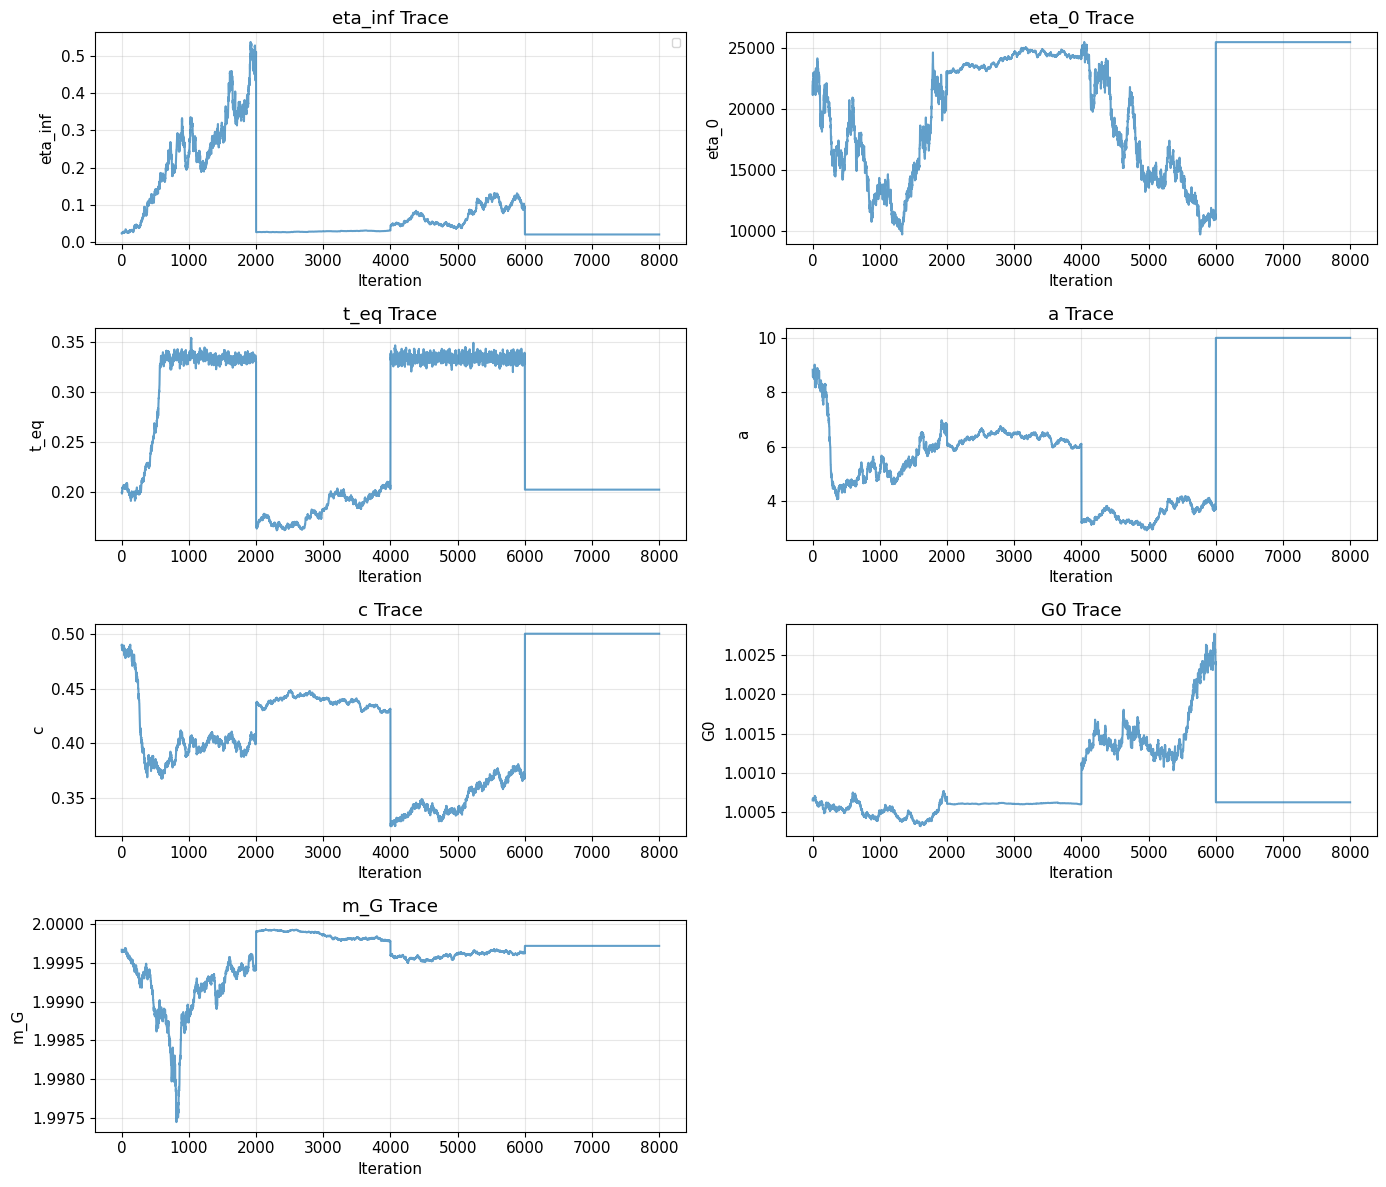

In [11]:
# Trace plots for convergence assessment
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, param_name in enumerate(param_names):
    if param_name in samples:
        param_samples = samples[param_name]
        # Flatten chains for plotting
        if param_samples.ndim == 2:  # (chains, samples)
            for chain in range(param_samples.shape[0]):
                axes[idx].plot(param_samples[chain, :], alpha=0.7, label=f'Chain {chain+1}')
        else:
            axes[idx].plot(param_samples, alpha=0.7)
        
        axes[idx].set_xlabel('Iteration')
        axes[idx].set_ylabel(param_name)
        axes[idx].set_title(f'{param_name} Trace')
        axes[idx].grid(True, alpha=0.3)
        if idx == 0:
            axes[idx].legend(fontsize=8)

# Hide extra subplot
if len(param_names) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
display(fig)
plt.close(fig)

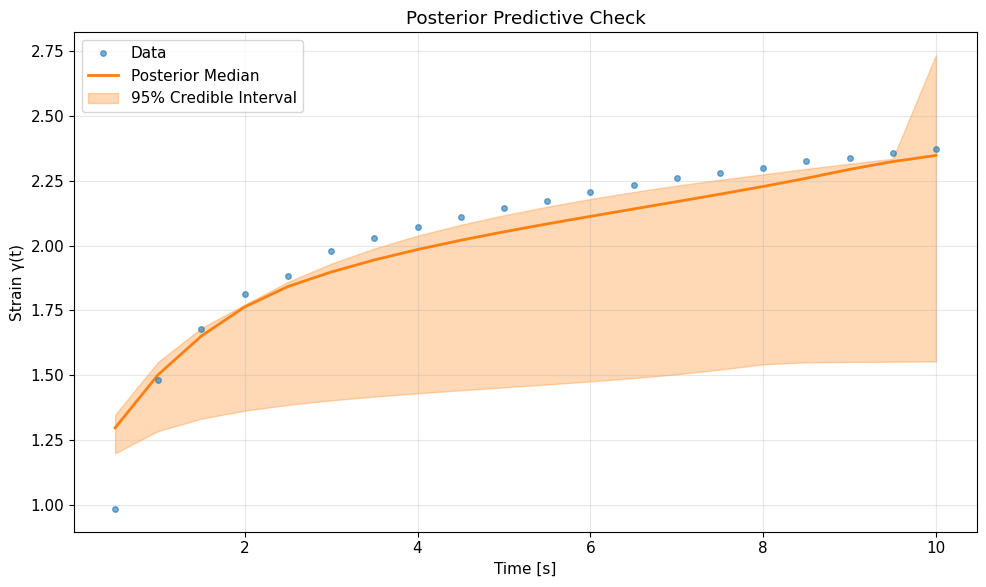

In [12]:
# Posterior predictive check
n_posterior_samples = 100
posterior_predictions = []

# Sample from posterior
for i in range(n_posterior_samples):
    # Random sample from flattened posterior
    idx = np.random.randint(0, samples[param_names[0]].size)
    
    # Get individual parameter values
    sample_eta_inf = float(samples['eta_inf'].flatten()[idx])
    sample_eta_0 = float(samples['eta_0'].flatten()[idx])
    sample_t_eq = float(samples['t_eq'].flatten()[idx])
    sample_a = float(samples['a'].flatten()[idx])
    sample_c = float(samples['c'].flatten()[idx])
    sample_G0 = float(samples['G0'].flatten()[idx])
    sample_m_G = float(samples['m_G'].flatten()[idx])
    
    # Predict using scipy-style wrapper
    gamma_pred_sample = dmt_creep_fn(
        time_data, sample_eta_inf, sample_eta_0, sample_t_eq, 
        sample_a, sample_c, sample_G0, sample_m_G
    )
    posterior_predictions.append(gamma_pred_sample)

posterior_predictions = jnp.array(posterior_predictions)

# Compute credible interval
lower_bound = jnp.percentile(posterior_predictions, 2.5, axis=0)
upper_bound = jnp.percentile(posterior_predictions, 97.5, axis=0)
median_pred = jnp.median(posterior_predictions, axis=0)

# Plot posterior predictive
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data', zorder=3)
ax.plot(time_data, median_pred, '-', linewidth=2, color='C1', label='Posterior Median', zorder=2)
ax.fill_between(time_data, lower_bound, upper_bound, alpha=0.3, color='C1', 
                 label='95% Credible Interval', zorder=1)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Strain γ(t)')
ax.set_title('Posterior Predictive Check')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## Physics: Viscosity Bifurcation Analysis

Now we explore how the DMT model predicts different behavior at different stress levels:

1. **Sub-yield regime**: Structure rebuilds faster than breakdown → bounded strain
2. **Critical regime**: Balance between rebuilding and breakdown → delayed yielding
3. **Supra-yield regime**: Breakdown dominates → unbounded flow

In [13]:
# Test multiple stress levels
stress_levels = jnp.array([0.5, 1.0, 5.0, 50.0])  # Pa
t_end = 500.0  # Extended time to see long-term behavior
dt=1.00

results = {}
for sigma in stress_levels:
    t, gamma, gamma_dot, lam = model.simulate_creep(
        sigma_0=float(sigma),
        t_end=t_end,
        dt=dt
    )
    results[float(sigma)] = {
        't': t,
        'gamma': gamma,
        'gamma_dot': gamma_dot,
        'lambda': lam
    }

print(f"Simulated creep at {len(stress_levels)} stress levels")
print(f"Stress range: {stress_levels[0]} - {stress_levels[-1]} Pa")

Simulated creep at 4 stress levels
Stress range: 0.5 - 50.0 Pa


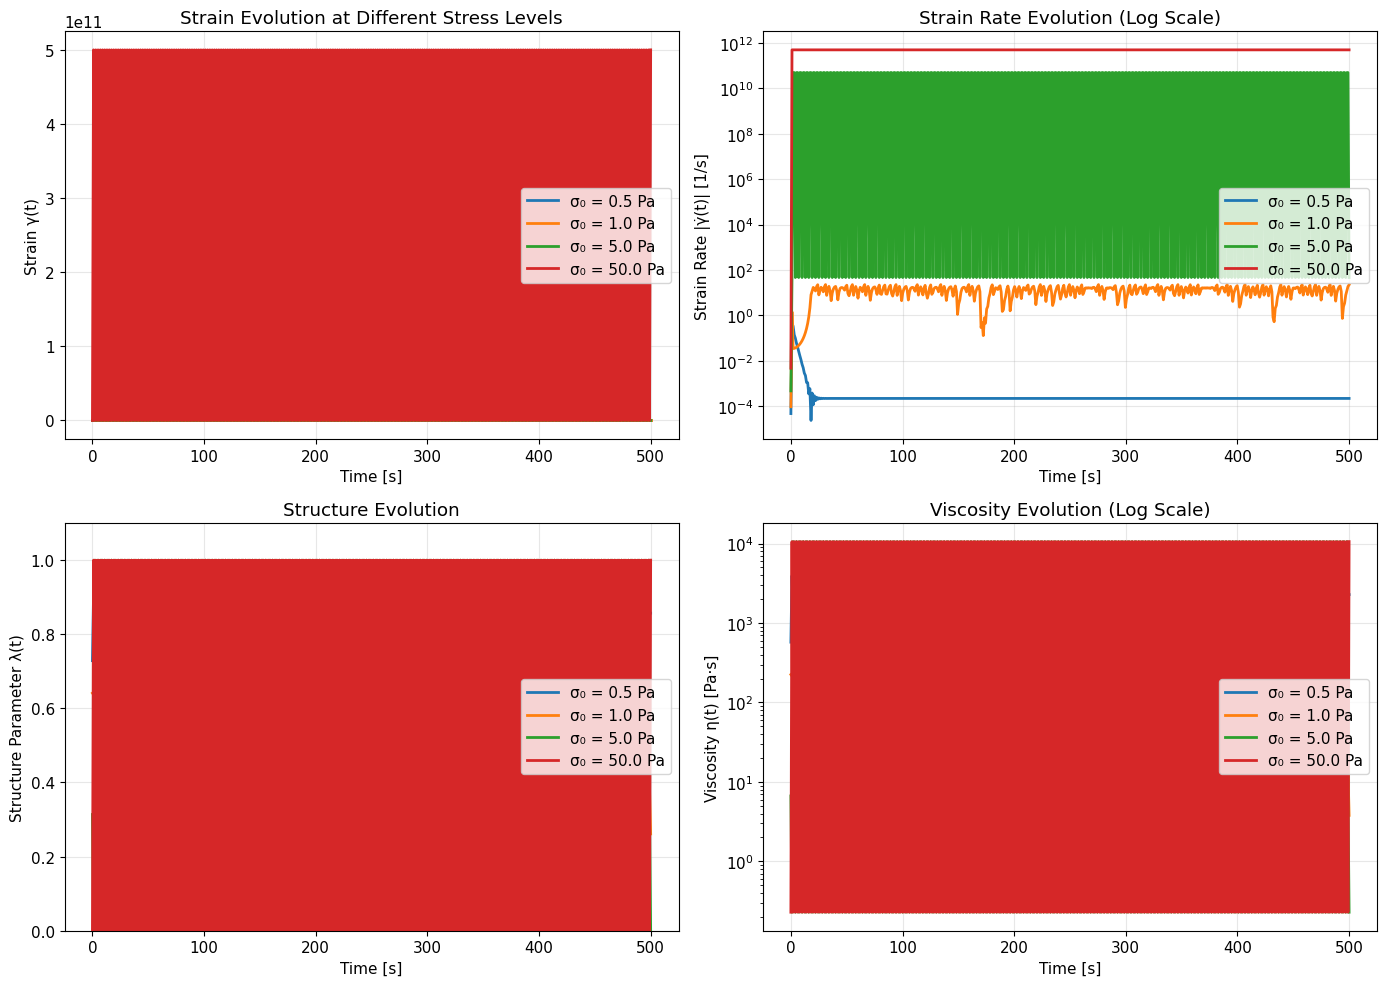

In [14]:
# Plot viscosity bifurcation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[0, 0].plot(data['t'], data['gamma'], linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Strain γ(t)')
axes[0, 0].set_title('Strain Evolution at Different Stress Levels')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Strain rate evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[0, 1].semilogy(data['t'], jnp.abs(data['gamma_dot']), linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Strain Rate |γ̇(t)| [1/s]')
axes[0, 1].set_title('Strain Rate Evolution (Log Scale)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Structure evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[1, 0].plot(data['t'], data['lambda'], linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Structure Parameter λ(t)')
axes[1, 0].set_title('Structure Evolution')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.1])

# Viscosity evolution (η = η_∞ * (η_0/η_∞)^λ)
eta_inf = model.parameters["eta_inf"].value
eta_0 = model.parameters["eta_0"].value
for sigma in stress_levels:
    data = results[float(sigma)]
    eta = eta_inf * (eta_0 / eta_inf) ** data['lambda']
    axes[1, 1].semilogy(data['t'], eta, linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Viscosity η(t) [Pa·s]')
axes[1, 1].set_title('Viscosity Evolution (Log Scale)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
display(fig)
plt.close(fig)

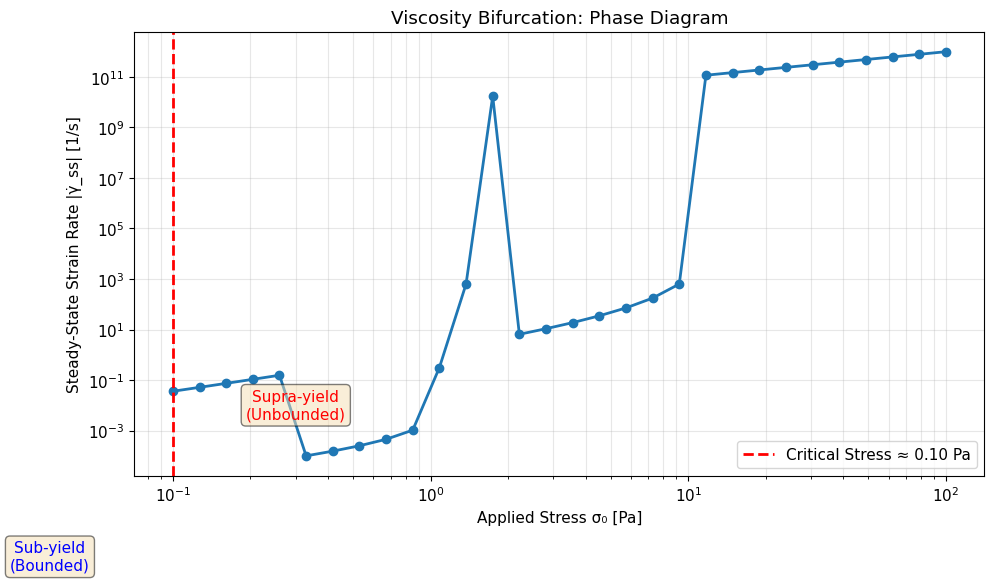


Estimated critical yield stress: σ_y ≈ 0.10 Pa


In [15]:
# Phase diagram: steady-state strain rate vs applied stress
# Identify critical yield stress

# Sample more stress levels for phase diagram
stress_scan = jnp.logspace(-1, 2, 30)  # 0.1 to 100 Pa
steady_state_rates = []

for sigma in stress_scan:
    t, gamma, gamma_dot, lam = model.simulate_creep(
        sigma_0=float(sigma),
        t_end=500.0,
        dt=1.0  # Use dt instead of n_points
    )
    # Take final strain rate as proxy for steady state
    steady_state_rates.append(float(jnp.abs(gamma_dot[-1])))

steady_state_rates = jnp.array(steady_state_rates)

# Find critical stress (where rate changes significantly)
# Use threshold: where steady rate > 1e-6 s^-1
yielding_mask = steady_state_rates > 1e-6
if jnp.any(yielding_mask):
    critical_stress_idx = jnp.where(yielding_mask)[0][0]
    critical_stress = stress_scan[critical_stress_idx]
else:
    critical_stress = None

# Plot phase diagram
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(stress_scan, steady_state_rates, 'o-', linewidth=2, markersize=6)

if critical_stress is not None:
    ax.axvline(critical_stress, color='red', linestyle='--', linewidth=2, 
               label=f'Critical Stress ≈ {critical_stress:.2f} Pa')

ax.set_xlabel('Applied Stress σ₀ [Pa]')
ax.set_ylabel('Steady-State Strain Rate |γ̇_ss| [1/s]')
ax.set_title('Viscosity Bifurcation: Phase Diagram')
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Add annotations
if critical_stress is not None:
    ax.text(critical_stress / 3, 1e-8, 'Sub-yield\n(Bounded)', 
            ha='center', va='center', fontsize=11, color='blue',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(critical_stress * 3, 1e-2, 'Supra-yield\n(Unbounded)', 
            ha='center', va='center', fontsize=11, color='red',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
display(fig)
plt.close(fig)

if critical_stress is not None:
    print(f"\nEstimated critical yield stress: σ_y ≈ {critical_stress:.2f} Pa")
else:
    print("\nNo clear yield stress identified in this stress range")

## Save Results

In [16]:
# Create output directory
output_dir = Path("../outputs/dmt/creep")
output_dir.mkdir(parents=True, exist_ok=True)

# Save NLSQ results
nlsq_output = output_dir / "mucus_creep_nlsq.txt"
with open(nlsq_output, 'w') as f:
    f.write("DMT Creep NLSQ Fitting Results\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Applied stress: {sigma_0} Pa\n")
    f.write(f"Data points: {len(time_data)}\n")
    f.write(f"R² score: {metrics['R2']:.6f}\n")
    f.write(f"RMSE: {metrics['RMSE']:.6e}\n\n")
    f.write("Fitted Parameters:\n")
    f.write("-" * 50 + "\n")
    for name, value in fitted_params.items():
        f.write(f"{name:12s}: {value:.6e}\n")

# Save Bayesian results
bayesian_output = output_dir / "mucus_creep_bayesian.txt"
with open(bayesian_output, 'w') as f:
    f.write("DMT Creep Bayesian Inference Results\n")
    f.write("=" * 50 + "\n\n")
    f.write("95% Credible Intervals:\n")
    f.write("-" * 50 + "\n")
    for param_name in param_names:
        if param_name in intervals:
            lower, upper = intervals[param_name]
            median = jnp.median(samples[param_name])
            f.write(f"{param_name:12s}: [{lower:.6e}, {upper:.6e}], median: {median:.6e}\n")

# Save bifurcation data
bifurcation_output = output_dir / "viscosity_bifurcation.csv"
bifurcation_data = np.column_stack([stress_scan, steady_state_rates])
np.savetxt(bifurcation_output, bifurcation_data, delimiter=',', 
           header='Stress[Pa],SteadyStateRate[1/s]', comments='')

print(f"Results saved to: {output_dir}")
print(f"  - NLSQ results: {nlsq_output.name}")
print(f"  - Bayesian results: {bayesian_output.name}")
print(f"  - Bifurcation data: {bifurcation_output.name}")

Results saved to: ../outputs/dmt/creep
  - NLSQ results: mucus_creep_nlsq.txt
  - Bayesian results: mucus_creep_bayesian.txt
  - Bifurcation data: viscosity_bifurcation.csv


## Key Takeaways

### Maxwell Creep Mechanics

1. **Elastic Jump**: Instantaneous response γ_e(0) = σ₀/G captures elastic storage
2. **Viscous Flow**: Time-dependent flow γ̇_v = σ₀/η(λ) driven by structure-dependent viscosity
3. **Structure Coupling**: Viscous flow rate feeds back to structure evolution

### Viscosity Bifurcation

1. **Sub-yield** (σ₀ < σ_y): Aging dominates → λ increases → η increases → flow stops
2. **Supra-yield** (σ₀ > σ_y): Rejuvenation dominates → λ decreases → η decreases → continuous flow
3. **Critical Stress**: Marks transition between bounded and unbounded creep

### Delayed Yielding

1. **Near σ_y**: Structure evolution timescale t_eq controls delay to steady state
2. **Biological Relevance**: Mucus under gravity vs applied pressure shows threshold behavior
3. **Thixotropic Signature**: Time-dependent yield transition characteristic of soft materials

### Practical Implications

- **Material Design**: Control t_eq, a, c to tune yielding behavior
- **Processing**: Apply stress above σ_y for continuous flow
- **Quality Control**: Measure creep compliance to infer yield stress and structure timescales